In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download"
output = "data_gaussian_2048.zip"
gdown.download(url, output)
!unzip data_gaussian_2048.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download
From (redirected): https://drive.google.com/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download&confirm=t&uuid=0cc38f63-ec43-4702-abde-9ef8ca52acfc
To: /content/data_gaussian_2048.zip
100%|██████████| 124M/124M [00:03<00:00, 37.7MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_2048/clean/images/1_1695.png  
  inflating: data_gaussian_2048/clean/images/1_1696.png  
  inflating: data_gaussian_2048/clean/images/1_1697.png  
  inflating: data_gaussian_2048/clean/images/1_1710.png  
  inflating: data_gaussian_2048/clean/images/1_1711.png  
  inflating: data_gaussian_2048/clean/images/1_1712.png  
  inflating: data_gaussian_2048/clean/images/1_1714.png  
  inflating: data_gaussian_2048/clean/images/1_1715.png  
  inflating: data_gaussian_2048/clean/images/1_1716.png  
  inflating: data_gaussian_2048/clean/images/1_1719.png  
  inflating: data_gaussian_2048/clean/images/1_1723.png  
  inflating: data_gaussian_2048/clean/images/1_1724.png  
  inflating: data_gaussian_2048/clean/images/1_1726.png  
  inflating: data_gaussian_2048/clean/images/1_1727.png  
  inflating: data_gaussian_2048/clean/images/1_1728.png  
  inflating: data_gaussian_2048/clean/images/1_1737.png  
  inflating: data_gaus

In [4]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_2048")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_2048/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:32<01:36, 32.07s/it]

jammed_channel



 50%|█████     | 2/4 [00:35<00:30, 15.31s/it]

test



 75%|███████▌  | 3/4 [00:41<00:10, 10.87s/it]

clean_validation



100%|██████████| 4/4 [00:43<00:00, 10.99s/it]


In [5]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [6]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



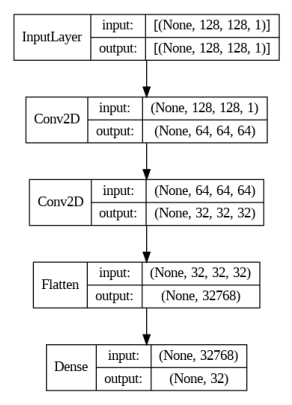

Summary of the decoder:



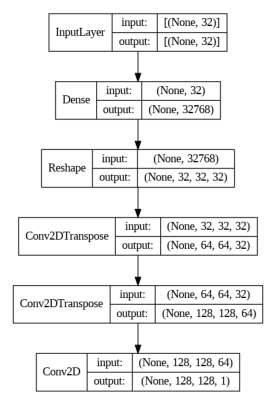

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [8]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 14s 59ms/step - loss: 0.0235 - val_loss: 0.0202
Epoch 2/20
125/125 [==============================] - 6s 50ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 3/20
125/125 [==============================] - 6s 50ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 4/20
125/125 [==============================] - 6s 49ms/step - loss: 0.0202 - val_loss: 0.0197
Epoch 5/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0193 - val_loss: 0.0170
Epoch 6/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 7/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 8/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 9/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 10/20
125/125 [==============================] - 6s 47ms/step - loss: 0.0142 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

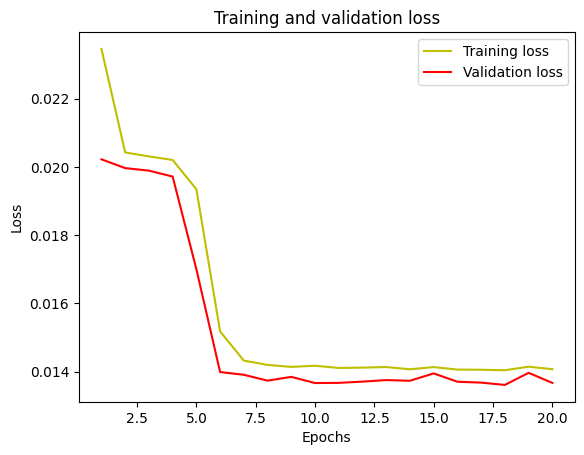

In [9]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 25ms/step


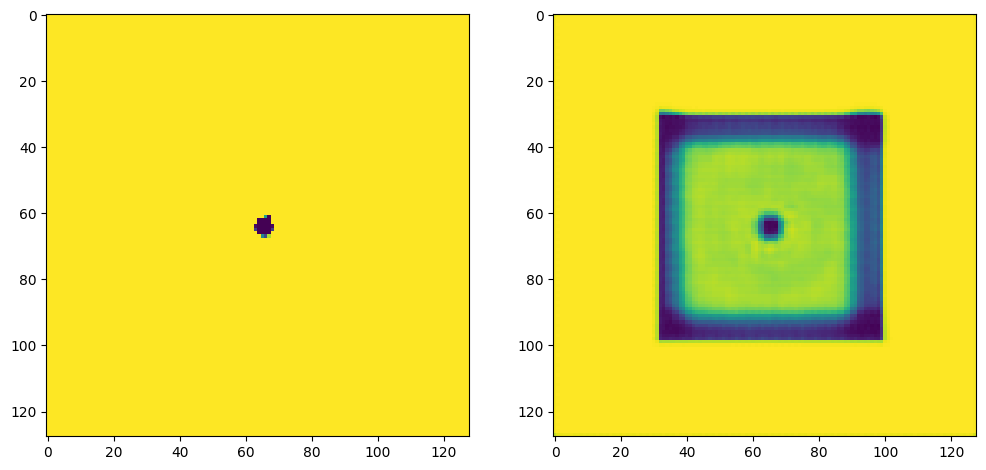

In [11]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [12]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 48ms/step - loss: 0.0760
Validation error 0.013673607259988785
Anomaly error 0.07599399983882904
The reconstruction error of the jammed channel is  5.557714097961548  more than the clean channel


In [13]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [14]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step - loss: 0.0185


  0%|          | 1/600 [00:00<02:18,  4.31it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0192


  0%|          | 2/600 [00:00<02:09,  4.62it/s]

1/1 [==============================] - 0s 101ms/step - loss: 0.0175


  0%|          | 3/600 [00:00<02:40,  3.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0192


  1%|          | 4/600 [00:00<02:20,  4.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0173


  1%|          | 5/600 [00:01<01:51,  5.31it/s]

1/1 [==============================] - 0s 66ms/step - loss: 0.0088


  1%|          | 6/600 [00:01<01:41,  5.83it/s]

1/1 [==============================] - 0s 89ms/step - loss: 0.0088


  1%|          | 7/600 [00:01<01:45,  5.64it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0173


  1%|▏         | 8/600 [00:01<01:33,  6.30it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0181


  2%|▏         | 9/600 [00:01<01:34,  6.24it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0094


  2%|▏         | 10/600 [00:01<01:35,  6.19it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0177


  2%|▏         | 11/600 [00:01<01:32,  6.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0179


  2%|▏         | 12/600 [00:02<01:22,  7.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


  2%|▏         | 13/600 [00:02<01:15,  7.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0195


  2%|▏         | 14/600 [00:02<01:12,  8.11it/s]

1/1 [==============================] - 0s 97ms/step - loss: 0.0093


  2%|▎         | 15/600 [00:02<01:20,  7.23it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0090


  3%|▎         | 16/600 [00:02<01:18,  7.41it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0093


  3%|▎         | 17/600 [00:02<01:15,  7.67it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0180


  3%|▎         | 18/600 [00:02<01:20,  7.25it/s]

1/1 [==============================] - 0s 93ms/step - loss: 0.0175


  3%|▎         | 19/600 [00:03<01:25,  6.76it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0189


  3%|▎         | 20/600 [00:03<01:27,  6.65it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0178


  4%|▎         | 21/600 [00:03<01:24,  6.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


  4%|▍         | 23/600 [00:03<01:03,  9.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0191


  4%|▍         | 25/600 [00:03<00:57,  9.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  4%|▍         | 27/600 [00:03<00:50, 11.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


  5%|▍         | 29/600 [00:03<00:46, 12.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


  5%|▌         | 31/600 [00:04<00:45, 12.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


  6%|▌         | 33/600 [00:04<00:42, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


  6%|▌         | 35/600 [00:04<00:42, 13.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


  6%|▌         | 37/600 [00:04<00:40, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


  6%|▋         | 39/600 [00:04<00:41, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0194


  7%|▋         | 41/600 [00:04<00:40, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


  7%|▋         | 43/600 [00:04<00:40, 13.80it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


  8%|▊         | 45/600 [00:05<00:40, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


  8%|▊         | 47/600 [00:05<00:39, 14.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0088


  8%|▊         | 49/600 [00:05<00:39, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


  8%|▊         | 51/600 [00:05<00:37, 14.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


  9%|▉         | 53/600 [00:05<00:37, 14.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


  9%|▉         | 55/600 [00:05<00:38, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 10%|▉         | 57/600 [00:05<00:38, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 10%|▉         | 59/600 [00:06<00:38, 13.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0170


 10%|█         | 61/600 [00:06<00:38, 14.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0190


 10%|█         | 63/600 [00:06<00:38, 13.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0165


 11%|█         | 65/600 [00:06<00:38, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0094


 11%|█         | 67/600 [00:06<00:39, 13.46it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0088


 12%|█▏        | 69/600 [00:06<00:43, 12.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0181


 12%|█▏        | 71/600 [00:07<00:49, 10.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0093


 12%|█▏        | 73/600 [00:07<00:51, 10.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0177


 12%|█▎        | 75/600 [00:07<00:50, 10.38it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0088


 13%|█▎        | 77/600 [00:07<00:52, 10.05it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0180


 13%|█▎        | 79/600 [00:07<00:51, 10.05it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0189


 14%|█▎        | 81/600 [00:08<00:53,  9.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 14%|█▍        | 83/600 [00:08<00:52,  9.93it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 14%|█▍        | 85/600 [00:08<00:51, 10.04it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0174


 14%|█▍        | 87/600 [00:08<00:50, 10.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0088


 15%|█▍        | 89/600 [00:08<00:51,  9.99it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0199


 15%|█▌        | 91/600 [00:09<00:50, 10.09it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 16%|█▌        | 93/600 [00:09<00:49, 10.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0094


 16%|█▌        | 95/600 [00:09<00:49, 10.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 16%|█▌        | 97/600 [00:09<00:45, 11.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 16%|█▋        | 99/600 [00:09<00:42, 11.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 17%|█▋        | 101/600 [00:09<00:40, 12.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 17%|█▋        | 103/600 [00:10<00:38, 12.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 18%|█▊        | 105/600 [00:10<00:37, 13.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 18%|█▊        | 107/600 [00:10<00:37, 13.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0197


 18%|█▊        | 109/600 [00:10<00:37, 13.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 18%|█▊        | 111/600 [00:10<00:36, 13.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0092


 19%|█▉        | 113/600 [00:10<00:36, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


 19%|█▉        | 115/600 [00:10<00:36, 13.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 20%|█▉        | 117/600 [00:11<00:36, 13.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 20%|█▉        | 119/600 [00:11<00:35, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0208


 20%|██        | 121/600 [00:11<00:35, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 20%|██        | 123/600 [00:11<00:34, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 21%|██        | 125/600 [00:11<00:33, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0093


 21%|██        | 127/600 [00:11<00:33, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0190


 22%|██▏       | 129/600 [00:11<00:33, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 22%|██▏       | 131/600 [00:12<00:32, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0168


 22%|██▏       | 133/600 [00:12<00:32, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 22%|██▎       | 135/600 [00:12<00:33, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 23%|██▎       | 137/600 [00:12<00:32, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0095


 23%|██▎       | 139/600 [00:12<00:32, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 24%|██▎       | 141/600 [00:12<00:32, 14.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0175


 24%|██▍       | 143/600 [00:12<00:32, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 24%|██▍       | 145/600 [00:13<00:31, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0093


 24%|██▍       | 147/600 [00:13<00:31, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 25%|██▍       | 149/600 [00:13<00:31, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 25%|██▌       | 151/600 [00:13<00:32, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 26%|██▌       | 153/600 [00:13<00:31, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 26%|██▌       | 155/600 [00:13<00:31, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 26%|██▌       | 157/600 [00:13<00:32, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 26%|██▋       | 159/600 [00:14<00:31, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 27%|██▋       | 161/600 [00:14<00:31, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0215


 27%|██▋       | 163/600 [00:14<00:31, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 28%|██▊       | 165/600 [00:14<00:31, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 28%|██▊       | 167/600 [00:14<00:31, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0195


 28%|██▊       | 169/600 [00:14<00:32, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0094


 28%|██▊       | 171/600 [00:14<00:31, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 29%|██▉       | 173/600 [00:15<00:31, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0204


 29%|██▉       | 175/600 [00:15<00:31, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


 30%|██▉       | 177/600 [00:15<00:30, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 30%|██▉       | 179/600 [00:15<00:30, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 30%|███       | 181/600 [00:15<00:30, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 30%|███       | 183/600 [00:15<00:31, 13.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 31%|███       | 185/600 [00:15<00:31, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0196


 31%|███       | 187/600 [00:16<00:30, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 32%|███▏      | 189/600 [00:16<00:30, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0216


 32%|███▏      | 191/600 [00:16<00:30, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 32%|███▏      | 193/600 [00:16<00:29, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 32%|███▎      | 195/600 [00:16<00:29, 13.95it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 33%|███▎      | 197/600 [00:16<00:29, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 33%|███▎      | 199/600 [00:17<00:29, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0093


 34%|███▎      | 201/600 [00:17<00:28, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0174


 34%|███▍      | 203/600 [00:17<00:28, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 34%|███▍      | 205/600 [00:17<00:28, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 34%|███▍      | 207/600 [00:17<00:28, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


 35%|███▍      | 209/600 [00:17<00:28, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0207


 35%|███▌      | 211/600 [00:17<00:27, 14.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0189


 36%|███▌      | 213/600 [00:18<00:28, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 36%|███▌      | 215/600 [00:18<00:27, 13.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0093


 36%|███▌      | 217/600 [00:18<00:27, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0190


 36%|███▋      | 219/600 [00:18<00:27, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0193


 37%|███▋      | 221/600 [00:18<00:27, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0094


 37%|███▋      | 223/600 [00:18<00:27, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 38%|███▊      | 225/600 [00:18<00:26, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0091


 38%|███▊      | 227/600 [00:19<00:27, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0169


 38%|███▊      | 229/600 [00:19<00:26, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 38%|███▊      | 231/600 [00:19<00:26, 13.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0092


 39%|███▉      | 233/600 [00:19<00:26, 13.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0093


 39%|███▉      | 235/600 [00:19<00:29, 12.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0169


 40%|███▉      | 237/600 [00:19<00:32, 11.23it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0217


 40%|███▉      | 239/600 [00:20<00:33, 10.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0185


 40%|████      | 241/600 [00:20<00:33, 10.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 40%|████      | 243/600 [00:20<00:33, 10.82it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0088


 41%|████      | 245/600 [00:20<00:33, 10.48it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0088


 41%|████      | 247/600 [00:20<00:34, 10.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0193


 42%|████▏     | 249/600 [00:21<00:34, 10.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0088


 42%|████▏     | 251/600 [00:21<00:33, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0198


 42%|████▏     | 253/600 [00:21<00:32, 10.56it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0209


 42%|████▎     | 255/600 [00:21<00:33, 10.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0088


 43%|████▎     | 257/600 [00:21<00:32, 10.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0170


 43%|████▎     | 259/600 [00:22<00:32, 10.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0174


 44%|████▎     | 261/600 [00:22<00:31, 10.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 44%|████▍     | 263/600 [00:22<00:29, 11.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


 44%|████▍     | 265/600 [00:22<00:27, 12.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 44%|████▍     | 267/600 [00:22<00:26, 12.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 45%|████▍     | 269/600 [00:22<00:25, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 45%|████▌     | 271/600 [00:22<00:25, 13.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0191


 46%|████▌     | 273/600 [00:23<00:24, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 46%|████▌     | 275/600 [00:23<00:24, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 46%|████▌     | 277/600 [00:23<00:23, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 46%|████▋     | 279/600 [00:23<00:23, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0163


 47%|████▋     | 281/600 [00:23<00:23, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0168


 47%|████▋     | 283/600 [00:23<00:23, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0189


 48%|████▊     | 285/600 [00:23<00:23, 13.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 48%|████▊     | 287/600 [00:24<00:23, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 48%|████▊     | 289/600 [00:24<00:22, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 48%|████▊     | 291/600 [00:24<00:22, 13.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 49%|████▉     | 293/600 [00:24<00:22, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 49%|████▉     | 295/600 [00:24<00:21, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 50%|████▉     | 297/600 [00:24<00:22, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 50%|████▉     | 299/600 [00:24<00:21, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


 50%|█████     | 301/600 [00:25<00:21, 13.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 50%|█████     | 303/600 [00:25<00:21, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 51%|█████     | 305/600 [00:25<00:20, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 51%|█████     | 307/600 [00:25<00:20, 14.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 52%|█████▏    | 309/600 [00:25<00:20, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


 52%|█████▏    | 311/600 [00:25<00:20, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 52%|█████▏    | 313/600 [00:25<00:19, 14.41it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0163


 52%|█████▎    | 315/600 [00:26<00:20, 14.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 53%|█████▎    | 317/600 [00:26<00:20, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 53%|█████▎    | 319/600 [00:26<00:20, 13.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 54%|█████▎    | 321/600 [00:26<00:20, 13.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0194


 54%|█████▍    | 323/600 [00:26<00:20, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0094


 54%|█████▍    | 325/600 [00:26<00:20, 13.17it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0191


 55%|█████▍    | 327/600 [00:27<00:20, 13.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 55%|█████▍    | 329/600 [00:27<00:21, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0163


 55%|█████▌    | 331/600 [00:27<00:20, 12.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0088


 56%|█████▌    | 333/600 [00:27<00:21, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 56%|█████▌    | 335/600 [00:27<00:20, 13.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 56%|█████▌    | 337/600 [00:27<00:19, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0093


 56%|█████▋    | 339/600 [00:27<00:18, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 57%|█████▋    | 341/600 [00:28<00:19, 13.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 57%|█████▋    | 343/600 [00:28<00:19, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 57%|█████▊    | 345/600 [00:28<00:19, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 58%|█████▊    | 347/600 [00:28<00:18, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0193


 58%|█████▊    | 349/600 [00:28<00:18, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0176


 58%|█████▊    | 351/600 [00:28<00:18, 13.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0189


 59%|█████▉    | 353/600 [00:28<00:18, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 59%|█████▉    | 355/600 [00:29<00:17, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 60%|█████▉    | 357/600 [00:29<00:17, 13.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 60%|█████▉    | 359/600 [00:29<00:17, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 60%|██████    | 361/600 [00:29<00:16, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 60%|██████    | 363/600 [00:29<00:17, 13.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 61%|██████    | 365/600 [00:29<00:16, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 61%|██████    | 367/600 [00:29<00:16, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 62%|██████▏   | 369/600 [00:30<00:16, 13.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0094


 62%|██████▏   | 371/600 [00:30<00:16, 13.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 62%|██████▏   | 373/600 [00:30<00:16, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 62%|██████▎   | 375/600 [00:30<00:16, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 63%|██████▎   | 377/600 [00:30<00:16, 13.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 63%|██████▎   | 379/600 [00:30<00:16, 13.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 64%|██████▎   | 381/600 [00:31<00:16, 13.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


 64%|██████▍   | 383/600 [00:31<00:16, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 64%|██████▍   | 385/600 [00:31<00:16, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 64%|██████▍   | 387/600 [00:31<00:15, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 65%|██████▍   | 389/600 [00:31<00:15, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 65%|██████▌   | 391/600 [00:31<00:15, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 66%|██████▌   | 393/600 [00:31<00:14, 13.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0219


 66%|██████▌   | 395/600 [00:32<00:14, 14.23it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 66%|██████▌   | 397/600 [00:32<00:14, 13.88it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0088


 66%|██████▋   | 399/600 [00:32<00:16, 12.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 67%|██████▋   | 401/600 [00:32<00:17, 11.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0093


 67%|██████▋   | 403/600 [00:32<00:17, 11.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 68%|██████▊   | 405/600 [00:32<00:17, 10.94it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0177


 68%|██████▊   | 407/600 [00:33<00:17, 10.95it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0088


 68%|██████▊   | 409/600 [00:33<00:17, 10.67it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 68%|██████▊   | 411/600 [00:33<00:18, 10.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0088


 69%|██████▉   | 413/600 [00:33<00:17, 10.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0093


 69%|██████▉   | 415/600 [00:33<00:17, 10.37it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0168


 70%|██████▉   | 417/600 [00:34<00:17, 10.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0211


 70%|██████▉   | 419/600 [00:34<00:17, 10.20it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0092


 70%|███████   | 421/600 [00:34<00:17, 10.18it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0088


 70%|███████   | 423/600 [00:34<00:17,  9.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 71%|███████   | 425/600 [00:34<00:16, 10.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 71%|███████   | 427/600 [00:35<00:15, 11.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0169


 72%|███████▏  | 429/600 [00:35<00:14, 12.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 72%|███████▏  | 431/600 [00:35<00:13, 12.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0094


 72%|███████▏  | 433/600 [00:35<00:13, 12.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0095


 72%|███████▎  | 435/600 [00:35<00:12, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 73%|███████▎  | 437/600 [00:35<00:12, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0206


 73%|███████▎  | 439/600 [00:35<00:12, 13.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 74%|███████▎  | 441/600 [00:36<00:12, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 74%|███████▍  | 443/600 [00:36<00:11, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 74%|███████▍  | 445/600 [00:36<00:11, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 74%|███████▍  | 447/600 [00:36<00:11, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 75%|███████▍  | 449/600 [00:36<00:11, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 75%|███████▌  | 451/600 [00:36<00:11, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 76%|███████▌  | 453/600 [00:37<00:10, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 76%|███████▌  | 455/600 [00:37<00:10, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 76%|███████▌  | 457/600 [00:37<00:10, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 76%|███████▋  | 459/600 [00:37<00:10, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 77%|███████▋  | 461/600 [00:37<00:10, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0193


 77%|███████▋  | 463/600 [00:37<00:10, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 78%|███████▊  | 465/600 [00:37<00:09, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0094


 78%|███████▊  | 467/600 [00:38<00:09, 13.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 78%|███████▊  | 469/600 [00:38<00:09, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 78%|███████▊  | 471/600 [00:38<00:09, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0220


 79%|███████▉  | 473/600 [00:38<00:09, 13.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0195


 79%|███████▉  | 475/600 [00:38<00:09, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 80%|███████▉  | 477/600 [00:38<00:09, 13.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 80%|███████▉  | 479/600 [00:38<00:09, 13.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 80%|████████  | 481/600 [00:39<00:08, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 80%|████████  | 483/600 [00:39<00:08, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 81%|████████  | 485/600 [00:39<00:08, 14.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0092


 81%|████████  | 487/600 [00:39<00:08, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 82%|████████▏ | 489/600 [00:39<00:08, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 82%|████████▏ | 491/600 [00:39<00:07, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 82%|████████▏ | 493/600 [00:39<00:07, 13.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0193


 82%|████████▎ | 495/600 [00:40<00:07, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0094


 83%|████████▎ | 497/600 [00:40<00:07, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 83%|████████▎ | 499/600 [00:40<00:07, 13.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 84%|████████▎ | 501/600 [00:40<00:07, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0191


 84%|████████▍ | 503/600 [00:40<00:07, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 84%|████████▍ | 505/600 [00:40<00:07, 13.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 84%|████████▍ | 507/600 [00:40<00:06, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 85%|████████▍ | 509/600 [00:41<00:06, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 85%|████████▌ | 511/600 [00:41<00:06, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 86%|████████▌ | 513/600 [00:41<00:06, 13.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 86%|████████▌ | 515/600 [00:41<00:06, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 86%|████████▌ | 517/600 [00:41<00:06, 13.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 86%|████████▋ | 519/600 [00:41<00:06, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 87%|████████▋ | 521/600 [00:42<00:05, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 87%|████████▋ | 523/600 [00:42<00:05, 13.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0174


 88%|████████▊ | 525/600 [00:42<00:05, 13.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 88%|████████▊ | 527/600 [00:42<00:05, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 88%|████████▊ | 529/600 [00:42<00:05, 13.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0165


 88%|████████▊ | 531/600 [00:42<00:05, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 89%|████████▉ | 533/600 [00:42<00:05, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 89%|████████▉ | 535/600 [00:43<00:04, 13.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 90%|████████▉ | 537/600 [00:43<00:04, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0173


 90%|████████▉ | 539/600 [00:43<00:04, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 90%|█████████ | 541/600 [00:43<00:04, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 90%|█████████ | 543/600 [00:43<00:04, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 91%|█████████ | 545/600 [00:43<00:04, 13.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 91%|█████████ | 547/600 [00:43<00:04, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0171


 92%|█████████▏| 549/600 [00:44<00:03, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0191


 92%|█████████▏| 551/600 [00:44<00:03, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 92%|█████████▏| 553/600 [00:44<00:03, 13.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 92%|█████████▎| 555/600 [00:44<00:03, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 93%|█████████▎| 557/600 [00:44<00:03, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0094


 93%|█████████▎| 559/600 [00:44<00:03, 13.64it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 94%|█████████▎| 561/600 [00:45<00:03, 12.04it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 94%|█████████▍| 563/600 [00:45<00:03, 11.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 94%|█████████▍| 565/600 [00:45<00:03, 10.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0093


 94%|█████████▍| 567/600 [00:45<00:03, 10.89it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0088


 95%|█████████▍| 569/600 [00:45<00:03, 10.32it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0178


 95%|█████████▌| 571/600 [00:46<00:02, 10.06it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 96%|█████████▌| 573/600 [00:46<00:02,  9.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0094


 96%|█████████▌| 575/600 [00:46<00:02, 10.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0094


 96%|█████████▌| 577/600 [00:46<00:02, 10.27it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0180


 96%|█████████▋| 579/600 [00:46<00:02, 10.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0088


 97%|█████████▋| 581/600 [00:47<00:01, 10.47it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0093


 97%|█████████▋| 583/600 [00:47<00:02,  6.58it/s]

1/1 [==============================] - 0s 90ms/step - loss: 0.0162


 97%|█████████▋| 584/600 [00:47<00:02,  6.21it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0088


 98%|█████████▊| 585/600 [00:48<00:02,  5.82it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0088


 98%|█████████▊| 586/600 [00:48<00:02,  6.07it/s]

1/1 [==============================] - 0s 83ms/step - loss: 0.0182


 98%|█████████▊| 587/600 [00:48<00:02,  5.94it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0199


 98%|█████████▊| 588/600 [00:48<00:01,  6.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0203


 98%|█████████▊| 589/600 [00:48<00:01,  6.56it/s]

1/1 [==============================] - 0s 108ms/step - loss: 0.0093


 98%|█████████▊| 590/600 [00:48<00:01,  5.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0175


 98%|█████████▊| 591/600 [00:49<00:01,  5.74it/s]

1/1 [==============================] - 0s 94ms/step - loss: 0.0193


 99%|█████████▊| 592/600 [00:49<00:01,  5.44it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0182


 99%|█████████▉| 593/600 [00:49<00:01,  5.89it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0093


 99%|█████████▉| 594/600 [00:49<00:01,  5.95it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0095


 99%|█████████▉| 596/600 [00:49<00:00,  7.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


100%|█████████▉| 598/600 [00:49<00:00,  9.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0778


  0%|          | 2/500 [00:00<00:38, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0754


  1%|          | 4/500 [00:00<00:37, 13.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


  1%|          | 6/500 [00:00<00:36, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0763


  2%|▏         | 8/500 [00:00<00:36, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


  2%|▏         | 10/500 [00:00<00:36, 13.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0759


  2%|▏         | 12/500 [00:00<00:37, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


  3%|▎         | 14/500 [00:01<00:36, 13.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0761


  3%|▎         | 16/500 [00:01<00:34, 13.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0753


  4%|▎         | 18/500 [00:01<00:34, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


  4%|▍         | 20/500 [00:01<00:34, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0753


  4%|▍         | 22/500 [00:01<00:33, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


  5%|▍         | 24/500 [00:01<00:34, 13.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0766


  5%|▌         | 26/500 [00:01<00:35, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0759


  6%|▌         | 28/500 [00:02<00:34, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0758


  6%|▌         | 30/500 [00:02<00:33, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0722


  6%|▋         | 32/500 [00:02<00:33, 13.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0768


  7%|▋         | 34/500 [00:02<00:34, 13.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0730


  7%|▋         | 36/500 [00:02<00:33, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0765


  8%|▊         | 38/500 [00:02<00:35, 12.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


  8%|▊         | 40/500 [00:02<00:34, 13.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0752


  8%|▊         | 42/500 [00:03<00:35, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


  9%|▉         | 44/500 [00:03<00:33, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0766


  9%|▉         | 46/500 [00:03<00:33, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0748


 10%|▉         | 48/500 [00:03<00:33, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 10%|█         | 50/500 [00:03<00:33, 13.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0762


 10%|█         | 52/500 [00:03<00:32, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0758


 11%|█         | 54/500 [00:03<00:33, 13.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0759


 11%|█         | 56/500 [00:04<00:33, 13.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0789


 12%|█▏        | 58/500 [00:04<00:33, 13.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0746


 12%|█▏        | 60/500 [00:04<00:32, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0761


 12%|█▏        | 62/500 [00:04<00:32, 13.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0757


 13%|█▎        | 64/500 [00:04<00:32, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0760


 13%|█▎        | 66/500 [00:04<00:32, 13.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0776


 14%|█▎        | 68/500 [00:05<00:33, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0757


 14%|█▍        | 70/500 [00:05<00:32, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 14%|█▍        | 72/500 [00:05<00:31, 13.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0762


 15%|█▍        | 74/500 [00:05<00:32, 13.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0762


 15%|█▌        | 76/500 [00:05<00:32, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0778


 16%|█▌        | 78/500 [00:05<00:32, 13.13it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0768


 16%|█▌        | 80/500 [00:05<00:32, 13.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0756


 16%|█▋        | 82/500 [00:06<00:31, 13.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0770


 17%|█▋        | 84/500 [00:06<00:31, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0745


 17%|█▋        | 86/500 [00:06<00:31, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


 18%|█▊        | 88/500 [00:06<00:31, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0754


 18%|█▊        | 90/500 [00:06<00:31, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 18%|█▊        | 92/500 [00:06<00:30, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0772


 19%|█▉        | 94/500 [00:07<00:30, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0757


 19%|█▉        | 96/500 [00:07<00:30, 13.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0767


 20%|█▉        | 98/500 [00:07<00:30, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


 20%|██        | 100/500 [00:07<00:29, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0764


 20%|██        | 102/500 [00:07<00:29, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0752


 21%|██        | 104/500 [00:07<00:29, 13.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0771


 21%|██        | 106/500 [00:07<00:31, 12.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0754


 22%|██▏       | 108/500 [00:08<00:33, 11.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0769


 22%|██▏       | 110/500 [00:08<00:35, 11.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0756


 22%|██▏       | 112/500 [00:08<00:35, 10.90it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0738


 23%|██▎       | 114/500 [00:08<00:36, 10.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0754


 23%|██▎       | 116/500 [00:08<00:36, 10.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0755


 24%|██▎       | 118/500 [00:09<00:38, 10.01it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0771


 24%|██▍       | 120/500 [00:09<00:37, 10.08it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0768


 24%|██▍       | 122/500 [00:09<00:37,  9.95it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0773


 25%|██▍       | 124/500 [00:09<00:38,  9.89it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0765


 25%|██▌       | 126/500 [00:09<00:39,  9.43it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0744


 25%|██▌       | 127/500 [00:10<00:40,  9.17it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0747


 26%|██▌       | 128/500 [00:10<00:41,  8.96it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0759


 26%|██▌       | 129/500 [00:10<00:40,  9.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0778


 26%|██▌       | 130/500 [00:10<00:40,  9.11it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0771


 26%|██▌       | 131/500 [00:10<00:40,  9.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0761


 27%|██▋       | 133/500 [00:10<00:35, 10.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 27%|██▋       | 135/500 [00:10<00:31, 11.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0751


 27%|██▋       | 137/500 [00:11<00:30, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0769


 28%|██▊       | 139/500 [00:11<00:29, 12.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0732


 28%|██▊       | 141/500 [00:11<00:29, 12.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0783


 29%|██▊       | 143/500 [00:11<00:27, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0756


 29%|██▉       | 145/500 [00:11<00:26, 13.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 29%|██▉       | 147/500 [00:11<00:26, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0733


 30%|██▉       | 149/500 [00:11<00:26, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0771


 30%|███       | 151/500 [00:12<00:26, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0753


 31%|███       | 153/500 [00:12<00:25, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0735


 31%|███       | 155/500 [00:12<00:25, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0770


 31%|███▏      | 157/500 [00:12<00:25, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0763


 32%|███▏      | 159/500 [00:12<00:24, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 32%|███▏      | 161/500 [00:12<00:24, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0763


 33%|███▎      | 163/500 [00:12<00:24, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0767


 33%|███▎      | 165/500 [00:13<00:24, 13.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0744


 33%|███▎      | 167/500 [00:13<00:25, 12.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 34%|███▍      | 169/500 [00:13<00:25, 13.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0765


 34%|███▍      | 171/500 [00:13<00:24, 13.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0763


 35%|███▍      | 173/500 [00:13<00:24, 13.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0761


 35%|███▌      | 175/500 [00:13<00:24, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0747


 35%|███▌      | 177/500 [00:14<00:24, 13.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0774


 36%|███▌      | 179/500 [00:14<00:24, 13.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


 36%|███▌      | 181/500 [00:14<00:24, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 37%|███▋      | 183/500 [00:14<00:23, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0743


 37%|███▋      | 185/500 [00:14<00:23, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0766


 37%|███▋      | 187/500 [00:14<00:23, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0781


 38%|███▊      | 189/500 [00:14<00:23, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0767


 38%|███▊      | 191/500 [00:15<00:23, 13.43it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0753


 39%|███▊      | 193/500 [00:15<00:23, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0768


 39%|███▉      | 195/500 [00:15<00:23, 12.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0768


 39%|███▉      | 197/500 [00:15<00:38,  7.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0751


 40%|███▉      | 199/500 [00:16<00:35,  8.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0770


 40%|████      | 201/500 [00:16<00:31,  9.43it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0767


 41%|████      | 203/500 [00:16<00:30,  9.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0727


 41%|████      | 205/500 [00:16<00:29, 10.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0748


 41%|████▏     | 207/500 [00:16<00:27, 10.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0773


 42%|████▏     | 209/500 [00:16<00:26, 10.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0751


 42%|████▏     | 211/500 [00:17<00:25, 11.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0777


 43%|████▎     | 213/500 [00:17<00:25, 11.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0746


 43%|████▎     | 215/500 [00:17<00:24, 11.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0758


 43%|████▎     | 217/500 [00:17<00:24, 11.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0752


 44%|████▍     | 219/500 [00:17<00:24, 11.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0755


 44%|████▍     | 221/500 [00:17<00:23, 11.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0731


 45%|████▍     | 223/500 [00:18<00:23, 11.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0762


 45%|████▌     | 225/500 [00:18<00:23, 11.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0760


 45%|████▌     | 227/500 [00:18<00:23, 11.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0761


 46%|████▌     | 229/500 [00:18<00:23, 11.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0754


 46%|████▌     | 231/500 [00:18<00:22, 11.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0756


 47%|████▋     | 233/500 [00:18<00:22, 12.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0780


 47%|████▋     | 235/500 [00:19<00:21, 12.35it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0753


 47%|████▋     | 237/500 [00:19<00:22, 11.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0757


 48%|████▊     | 239/500 [00:19<00:23, 11.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0784


 48%|████▊     | 241/500 [00:19<00:22, 11.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0757


 49%|████▊     | 243/500 [00:19<00:21, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0761


 49%|████▉     | 245/500 [00:19<00:21, 11.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0760


 49%|████▉     | 247/500 [00:20<00:21, 12.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0761


 50%|████▉     | 249/500 [00:20<00:20, 12.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0762


 50%|█████     | 251/500 [00:20<00:20, 12.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0745


 51%|█████     | 253/500 [00:20<00:20, 11.93it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0751


 51%|█████     | 255/500 [00:20<00:22, 10.90it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0754


 51%|█████▏    | 257/500 [00:21<00:24,  9.77it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0750


 52%|█████▏    | 259/500 [00:21<00:24,  9.93it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0756


 52%|█████▏    | 261/500 [00:21<00:25,  9.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0766


 53%|█████▎    | 263/500 [00:21<00:23,  9.91it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0768


 53%|█████▎    | 265/500 [00:21<00:23,  9.90it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0760


 53%|█████▎    | 267/500 [00:22<00:23,  9.82it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0758


 54%|█████▎    | 268/500 [00:22<00:24,  9.62it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0756


 54%|█████▍    | 269/500 [00:22<00:24,  9.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0765


 54%|█████▍    | 270/500 [00:22<00:24,  9.24it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0769


 54%|█████▍    | 271/500 [00:22<00:24,  9.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0744


 55%|█████▍    | 273/500 [00:22<00:23,  9.82it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0765


 55%|█████▌    | 275/500 [00:22<00:22, 10.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0766


 55%|█████▌    | 276/500 [00:23<00:23,  9.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0765


 55%|█████▌    | 277/500 [00:23<00:22,  9.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0768


 56%|█████▌    | 278/500 [00:23<00:22,  9.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0759


 56%|█████▌    | 279/500 [00:23<00:22,  9.68it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0760


 56%|█████▌    | 280/500 [00:23<00:23,  9.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0748


 56%|█████▋    | 282/500 [00:23<00:21, 10.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0754


 57%|█████▋    | 284/500 [00:23<00:19, 11.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 57%|█████▋    | 286/500 [00:23<00:18, 11.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0775


 58%|█████▊    | 288/500 [00:24<00:17, 12.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0763


 58%|█████▊    | 290/500 [00:24<00:16, 12.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0759


 58%|█████▊    | 292/500 [00:24<00:16, 12.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0761


 59%|█████▉    | 294/500 [00:24<00:16, 12.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


 59%|█████▉    | 296/500 [00:24<00:16, 12.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 60%|█████▉    | 298/500 [00:24<00:15, 13.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0744


 60%|██████    | 300/500 [00:25<00:15, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0743


 60%|██████    | 302/500 [00:25<00:14, 13.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0751


 61%|██████    | 304/500 [00:25<00:15, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0763


 61%|██████    | 306/500 [00:25<00:14, 13.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0754


 62%|██████▏   | 308/500 [00:25<00:14, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0761


 62%|██████▏   | 310/500 [00:25<00:14, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0756


 62%|██████▏   | 312/500 [00:25<00:14, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0779


 63%|██████▎   | 314/500 [00:26<00:14, 12.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0779


 63%|██████▎   | 316/500 [00:26<00:14, 12.81it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0772


 64%|██████▎   | 318/500 [00:26<00:14, 12.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0754


 64%|██████▍   | 320/500 [00:26<00:14, 12.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0764


 64%|██████▍   | 322/500 [00:26<00:14, 12.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 65%|██████▍   | 324/500 [00:26<00:13, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0759


 65%|██████▌   | 326/500 [00:27<00:13, 12.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0781


 66%|██████▌   | 328/500 [00:27<00:13, 13.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0748


 66%|██████▌   | 330/500 [00:27<00:13, 12.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0766


 66%|██████▋   | 332/500 [00:27<00:12, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0742


 67%|██████▋   | 334/500 [00:27<00:12, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0762


 67%|██████▋   | 336/500 [00:27<00:12, 13.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0759


 68%|██████▊   | 338/500 [00:27<00:12, 13.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0768


 68%|██████▊   | 340/500 [00:28<00:12, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 68%|██████▊   | 342/500 [00:28<00:11, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 69%|██████▉   | 344/500 [00:28<00:12, 12.95it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0764


 69%|██████▉   | 346/500 [00:28<00:11, 12.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0758


 70%|██████▉   | 348/500 [00:28<00:11, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 70%|███████   | 350/500 [00:28<00:11, 13.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0765


 70%|███████   | 352/500 [00:29<00:11, 13.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0765


 71%|███████   | 354/500 [00:29<00:11, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 71%|███████   | 356/500 [00:29<00:10, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0741


 72%|███████▏  | 358/500 [00:29<00:10, 13.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0750


 72%|███████▏  | 360/500 [00:29<00:10, 13.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0771


 72%|███████▏  | 362/500 [00:29<00:10, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0760


 73%|███████▎  | 364/500 [00:29<00:10, 12.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0760


 73%|███████▎  | 366/500 [00:30<00:10, 12.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0784


 74%|███████▎  | 368/500 [00:30<00:10, 12.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0749


 74%|███████▍  | 370/500 [00:30<00:09, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0760


 74%|███████▍  | 372/500 [00:30<00:09, 13.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0764


 75%|███████▍  | 374/500 [00:30<00:09, 12.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0770


 75%|███████▌  | 376/500 [00:30<00:09, 12.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0764


 76%|███████▌  | 378/500 [00:31<00:09, 13.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0741


 76%|███████▌  | 380/500 [00:31<00:09, 13.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0761


 76%|███████▋  | 382/500 [00:31<00:08, 13.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0778


 77%|███████▋  | 384/500 [00:31<00:08, 13.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0758


 77%|███████▋  | 386/500 [00:31<00:08, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0759


 78%|███████▊  | 388/500 [00:31<00:08, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 78%|███████▊  | 390/500 [00:31<00:08, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0758


 78%|███████▊  | 392/500 [00:32<00:08, 13.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0740


 79%|███████▉  | 394/500 [00:32<00:07, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0762


 79%|███████▉  | 396/500 [00:32<00:07, 13.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0781


 80%|███████▉  | 398/500 [00:32<00:07, 13.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0752


 80%|████████  | 400/500 [00:32<00:07, 13.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0762


 80%|████████  | 402/500 [00:32<00:07, 13.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0772


 81%|████████  | 404/500 [00:32<00:07, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0749


 81%|████████  | 406/500 [00:33<00:07, 13.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0767


 82%|████████▏ | 408/500 [00:33<00:07, 12.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0758


 82%|████████▏ | 410/500 [00:33<00:06, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0761


 82%|████████▏ | 412/500 [00:33<00:06, 13.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0753


 83%|████████▎ | 414/500 [00:33<00:07, 12.04it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0763


 83%|████████▎ | 416/500 [00:34<00:07, 10.96it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0764


 84%|████████▎ | 418/500 [00:34<00:07, 10.86it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0759


 84%|████████▍ | 420/500 [00:34<00:07, 10.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0772


 84%|████████▍ | 422/500 [00:34<00:07, 10.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0760


 85%|████████▍ | 424/500 [00:34<00:07, 10.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0756


 85%|████████▌ | 426/500 [00:34<00:07, 10.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0765


 86%|████████▌ | 428/500 [00:35<00:06, 10.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0767


 86%|████████▌ | 430/500 [00:35<00:06, 10.41it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0770


 86%|████████▋ | 432/500 [00:35<00:06, 10.19it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0762


 87%|████████▋ | 434/500 [00:35<00:06,  9.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0764


 87%|████████▋ | 435/500 [00:35<00:06,  9.78it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0749


 87%|████████▋ | 436/500 [00:36<00:06,  9.42it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0774


 87%|████████▋ | 437/500 [00:36<00:06,  9.39it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0736


 88%|████████▊ | 438/500 [00:36<00:06,  9.30it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0760


 88%|████████▊ | 439/500 [00:36<00:06,  9.16it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0765


 88%|████████▊ | 440/500 [00:36<00:06,  9.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0747


 88%|████████▊ | 442/500 [00:36<00:05,  9.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0764


 89%|████████▉ | 444/500 [00:36<00:05,  9.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0755


 89%|████████▉ | 446/500 [00:37<00:05, 10.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0759


 90%|████████▉ | 448/500 [00:37<00:04, 11.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0759


 90%|█████████ | 450/500 [00:37<00:04, 11.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0757


 90%|█████████ | 452/500 [00:37<00:03, 12.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0743


 91%|█████████ | 454/500 [00:37<00:03, 12.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0764


 91%|█████████ | 456/500 [00:37<00:03, 12.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0740


 92%|█████████▏| 458/500 [00:37<00:03, 12.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0769


 92%|█████████▏| 460/500 [00:38<00:03, 12.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0757


 92%|█████████▏| 462/500 [00:38<00:03, 12.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0759


 93%|█████████▎| 464/500 [00:38<00:02, 12.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0764


 93%|█████████▎| 466/500 [00:38<00:02, 12.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0742


 94%|█████████▎| 468/500 [00:38<00:02, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0759


 94%|█████████▍| 470/500 [00:38<00:02, 12.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0762


 94%|█████████▍| 472/500 [00:39<00:02, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0774


 95%|█████████▍| 474/500 [00:39<00:01, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0752


 95%|█████████▌| 476/500 [00:39<00:01, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0766


 96%|█████████▌| 478/500 [00:39<00:01, 13.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0745


 96%|█████████▌| 480/500 [00:39<00:01, 12.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0743


 96%|█████████▋| 482/500 [00:39<00:01, 13.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0761


 97%|█████████▋| 484/500 [00:39<00:01, 12.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0769


 97%|█████████▋| 486/500 [00:40<00:01, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


 98%|█████████▊| 488/500 [00:40<00:00, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0765


 98%|█████████▊| 490/500 [00:40<00:00, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0757


 98%|█████████▊| 492/500 [00:40<00:00, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0752


 99%|█████████▉| 494/500 [00:40<00:00, 13.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0737


 99%|█████████▉| 496/500 [00:40<00:00, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0759


100%|█████████▉| 498/500 [00:41<00:00, 13.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0769


100%|██████████| 500/500 [00:41<00:00, 12.14it/s]


In [15]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.013673606491647661 
Standard deviation of the reconstruction error of the clean channel: 0.004796241348948498
Mean of the reconstruction error of the jammed channel: 0.07599400074779987 
Standard deviation of the reconstruction error of the jammed channel: 0.0010722469263479808
Maximum of the reconstruction error of the clean channel: 0.0235728956758976 and minimum: 0.008750359527766705
Maximum of the reconstruction error of the jammed channel: 0.078935906291008 and minimum: 0.0721883475780487


In [16]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [17]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 35ms/step - loss: 0.0088


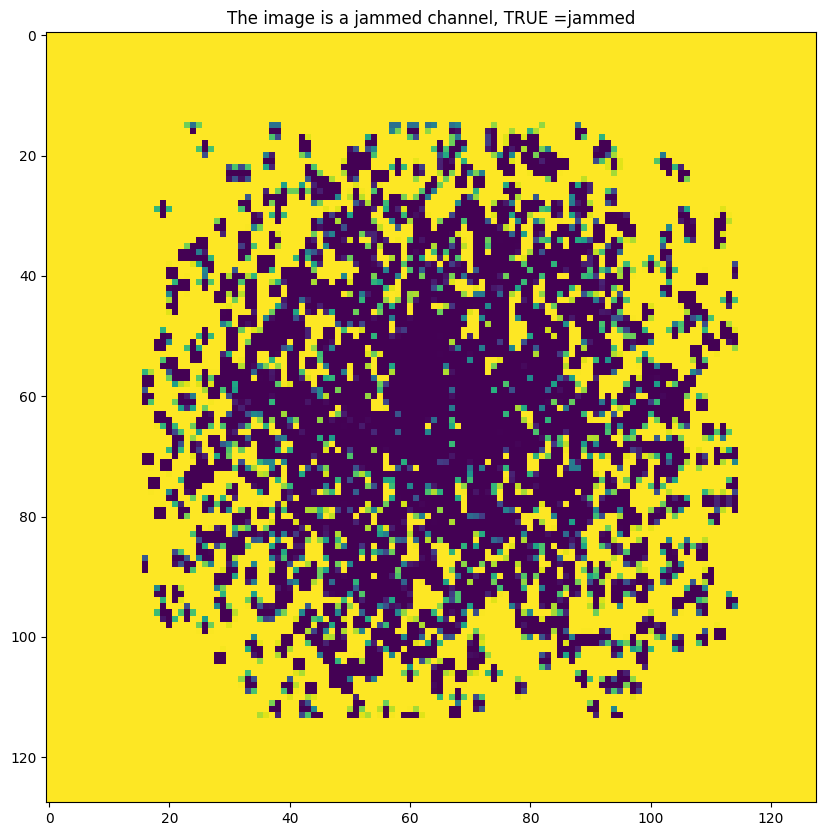

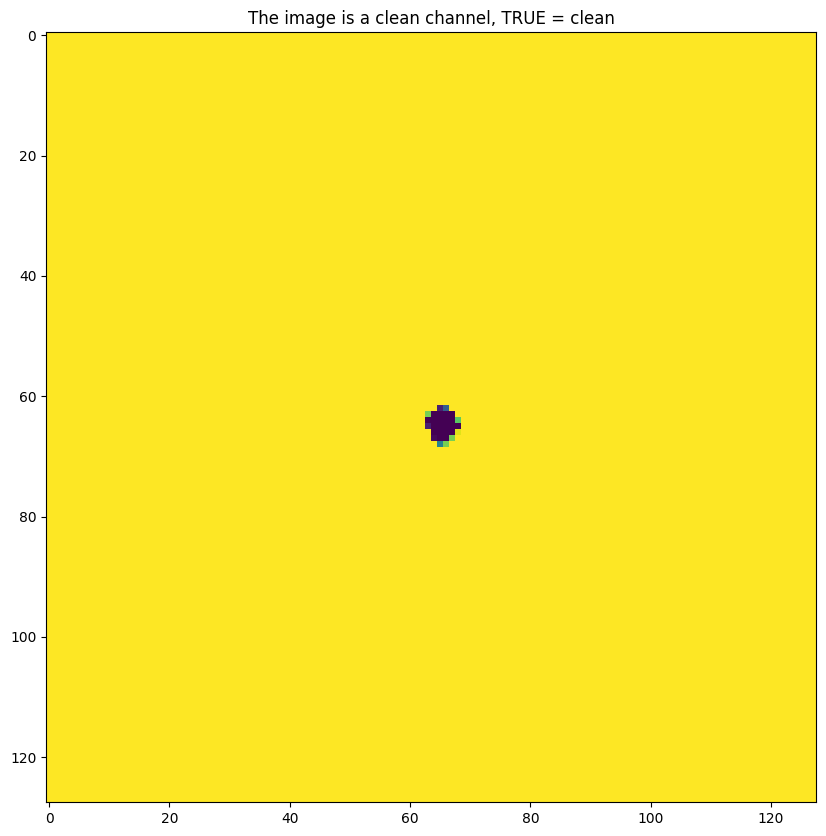

In [18]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [19]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [21]:
values_th=np.arange(min_range_th,max_range_th,0.0008) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

88


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 147ms/step - loss: 0.0177


  0%|          | 1/800 [00:00<06:18,  2.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0094


  0%|          | 2/800 [00:00<03:58,  3.35it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0175


  0%|          | 3/800 [00:00<02:46,  4.80it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0768


  1%|          | 5/800 [00:00<01:52,  7.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0092


  1%|          | 7/800 [00:01<01:27,  9.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0748


  1%|          | 9/800 [00:01<01:14, 10.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0766


  1%|▏         | 11/800 [00:01<01:06, 11.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


  2%|▏         | 13/800 [00:01<01:02, 12.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


  2%|▏         | 15/800 [00:01<00:57, 13.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0193


  2%|▏         | 17/800 [00:01<00:54, 14.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


  2%|▏         | 19/800 [00:01<00:53, 14.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0743


  3%|▎         | 21/800 [00:01<00:52, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


  3%|▎         | 23/800 [00:02<00:51, 15.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0093


  3%|▎         | 25/800 [00:02<00:52, 14.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0167


  3%|▎         | 27/800 [00:02<00:52, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  4%|▎         | 29/800 [00:02<00:51, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0196


  4%|▍         | 31/800 [00:02<00:53, 14.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0778


  4%|▍         | 33/800 [00:02<00:53, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0164


  4%|▍         | 35/800 [00:02<00:52, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


  5%|▍         | 37/800 [00:03<00:50, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


  5%|▍         | 39/800 [00:03<00:49, 15.30it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0175


  5%|▌         | 41/800 [00:03<00:49, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


  5%|▌         | 43/800 [00:03<00:49, 15.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


  6%|▌         | 45/800 [00:03<00:49, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0769


  6%|▌         | 47/800 [00:03<00:49, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


  6%|▌         | 49/800 [00:03<00:48, 15.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


  6%|▋         | 51/800 [00:03<00:49, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0763


  7%|▋         | 53/800 [00:04<00:49, 14.99it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0088


  7%|▋         | 55/800 [00:04<00:50, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


  7%|▋         | 57/800 [00:04<00:50, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0772


  7%|▋         | 59/800 [00:04<00:50, 14.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0754


  8%|▊         | 61/800 [00:04<00:49, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0382


  8%|▊         | 63/800 [00:04<00:49, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


  8%|▊         | 65/800 [00:04<00:49, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


  8%|▊         | 67/800 [00:05<00:48, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0759


  9%|▊         | 69/800 [00:05<00:47, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


  9%|▉         | 71/800 [00:05<00:48, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0737


  9%|▉         | 73/800 [00:05<00:49, 14.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0767


  9%|▉         | 75/800 [00:05<00:47, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 10%|▉         | 77/800 [00:05<00:46, 15.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0196


 10%|▉         | 79/800 [00:05<00:47, 15.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 10%|█         | 81/800 [00:05<00:48, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 10%|█         | 83/800 [00:06<00:47, 15.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0763


 11%|█         | 85/800 [00:06<00:47, 14.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 11%|█         | 87/800 [00:06<00:47, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0758


 11%|█         | 89/800 [00:06<00:48, 14.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0758


 11%|█▏        | 91/800 [00:06<00:48, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 12%|█▏        | 93/800 [00:06<00:46, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0758


 12%|█▏        | 95/800 [00:06<00:45, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0744


 12%|█▏        | 97/800 [00:07<00:47, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0749


 12%|█▏        | 99/800 [00:07<00:46, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


 13%|█▎        | 101/800 [00:07<00:45, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0192


 13%|█▎        | 103/800 [00:07<00:45, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0734


 13%|█▎        | 105/800 [00:07<00:43, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0761


 13%|█▎        | 107/800 [00:07<00:45, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 14%|█▎        | 109/800 [00:07<00:45, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 14%|█▍        | 111/800 [00:07<00:44, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 14%|█▍        | 113/800 [00:08<00:44, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0752


 14%|█▍        | 115/800 [00:08<00:44, 15.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0751


 15%|█▍        | 117/800 [00:08<00:45, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0717


 15%|█▍        | 119/800 [00:08<00:46, 14.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0762


 15%|█▌        | 121/800 [00:08<00:44, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 15%|█▌        | 123/800 [00:08<00:44, 15.21it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0760


 16%|█▌        | 125/800 [00:08<00:44, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 16%|█▌        | 127/800 [00:09<00:43, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 16%|█▌        | 129/800 [00:09<00:43, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0753


 16%|█▋        | 131/800 [00:09<00:42, 15.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 17%|█▋        | 133/800 [00:09<00:42, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 17%|█▋        | 135/800 [00:09<00:42, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0773


 17%|█▋        | 137/800 [00:09<00:41, 15.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0166


 17%|█▋        | 139/800 [00:09<00:41, 16.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0170


 18%|█▊        | 141/800 [00:09<00:40, 16.30it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0753


 18%|█▊        | 143/800 [00:10<00:41, 15.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 18%|█▊        | 145/800 [00:10<00:40, 16.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 18%|█▊        | 147/800 [00:10<00:40, 16.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 19%|█▊        | 149/800 [00:10<00:40, 15.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 19%|█▉        | 151/800 [00:10<00:41, 15.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


 19%|█▉        | 153/800 [00:10<00:43, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0190


 19%|█▉        | 155/800 [00:10<00:42, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0759


 20%|█▉        | 157/800 [00:10<00:41, 15.64it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0762


 20%|█▉        | 159/800 [00:11<00:43, 14.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 20%|██        | 161/800 [00:11<00:46, 13.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0771


 20%|██        | 163/800 [00:11<00:48, 13.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0781


 21%|██        | 165/800 [00:11<00:52, 12.19it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0168


 21%|██        | 167/800 [00:11<00:53, 11.81it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0771


 21%|██        | 169/800 [00:11<00:56, 11.21it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0190


 21%|██▏       | 171/800 [00:12<00:57, 11.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0172


 22%|██▏       | 173/800 [00:12<00:56, 11.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0743


 22%|██▏       | 175/800 [00:12<00:54, 11.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0770


 22%|██▏       | 177/800 [00:12<00:55, 11.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0770


 22%|██▏       | 179/800 [00:12<00:55, 11.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0758


 23%|██▎       | 181/800 [00:13<00:53, 11.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0095


 23%|██▎       | 183/800 [00:13<00:54, 11.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0771


 23%|██▎       | 185/800 [00:13<00:54, 11.31it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0760


 23%|██▎       | 187/800 [00:13<00:56, 10.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 24%|██▎       | 189/800 [00:13<00:52, 11.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 24%|██▍       | 191/800 [00:13<00:49, 12.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0763


 24%|██▍       | 193/800 [00:13<00:45, 13.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0752


 24%|██▍       | 195/800 [00:14<00:45, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0170


 25%|██▍       | 197/800 [00:14<00:43, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 25%|██▍       | 199/800 [00:14<00:42, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0753


 25%|██▌       | 201/800 [00:14<00:41, 14.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 25%|██▌       | 203/800 [00:14<00:42, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0770


 26%|██▌       | 205/800 [00:14<00:42, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0748


 26%|██▌       | 207/800 [00:14<00:41, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0193


 26%|██▌       | 209/800 [00:15<00:41, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 26%|██▋       | 211/800 [00:15<00:40, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0193


 27%|██▋       | 213/800 [00:15<00:39, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0762


 27%|██▋       | 215/800 [00:15<00:39, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0391


 27%|██▋       | 217/800 [00:15<00:38, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0763


 27%|██▋       | 219/800 [00:15<00:39, 14.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0756


 28%|██▊       | 221/800 [00:15<00:38, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0747


 28%|██▊       | 223/800 [00:16<00:37, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 28%|██▊       | 225/800 [00:16<00:37, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0781


 28%|██▊       | 227/800 [00:16<00:37, 15.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0750


 29%|██▊       | 229/800 [00:16<00:38, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 29%|██▉       | 231/800 [00:16<00:37, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0166


 29%|██▉       | 233/800 [00:16<00:37, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0774


 29%|██▉       | 235/800 [00:16<00:36, 15.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


 30%|██▉       | 237/800 [00:16<00:36, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 30%|██▉       | 239/800 [00:17<00:36, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


 30%|███       | 241/800 [00:17<00:35, 15.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0764


 30%|███       | 243/800 [00:17<00:35, 15.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0766


 31%|███       | 245/800 [00:17<00:35, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0172


 31%|███       | 247/800 [00:17<00:35, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0755


 31%|███       | 249/800 [00:17<00:36, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 31%|███▏      | 251/800 [00:17<00:37, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0764


 32%|███▏      | 253/800 [00:17<00:36, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0767


 32%|███▏      | 255/800 [00:18<00:36, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 32%|███▏      | 257/800 [00:18<00:36, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 32%|███▏      | 259/800 [00:18<00:36, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0199


 33%|███▎      | 261/800 [00:18<00:36, 14.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0765


 33%|███▎      | 263/800 [00:18<00:36, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0162


 33%|███▎      | 265/800 [00:18<00:37, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0752


 33%|███▎      | 267/800 [00:18<00:36, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0763


 34%|███▎      | 269/800 [00:19<00:36, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


 34%|███▍      | 271/800 [00:19<00:35, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 34%|███▍      | 273/800 [00:19<00:34, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0754


 34%|███▍      | 275/800 [00:19<00:35, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 35%|███▍      | 277/800 [00:19<00:34, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0167


 35%|███▍      | 279/800 [00:19<00:34, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 35%|███▌      | 281/800 [00:19<00:35, 14.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0154


 35%|███▌      | 283/800 [00:20<00:35, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0151


 36%|███▌      | 285/800 [00:20<00:33, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0763


 36%|███▌      | 287/800 [00:20<00:34, 14.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0747


 36%|███▌      | 289/800 [00:20<00:34, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 36%|███▋      | 291/800 [00:20<00:33, 15.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 37%|███▋      | 293/800 [00:20<00:32, 15.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 37%|███▋      | 295/800 [00:20<00:32, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 37%|███▋      | 297/800 [00:20<00:32, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0751


 37%|███▋      | 299/800 [00:21<00:32, 15.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0094


 38%|███▊      | 301/800 [00:21<00:32, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0752


 38%|███▊      | 303/800 [00:21<00:32, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0765


 38%|███▊      | 305/800 [00:21<00:32, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0779


 38%|███▊      | 307/800 [00:21<00:32, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0198


 39%|███▊      | 309/800 [00:21<00:31, 15.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 39%|███▉      | 311/800 [00:21<00:32, 15.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0088


 39%|███▉      | 313/800 [00:21<00:31, 15.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 39%|███▉      | 315/800 [00:22<00:31, 15.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0761


 40%|███▉      | 317/800 [00:22<00:31, 15.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 40%|███▉      | 319/800 [00:22<00:32, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


 40%|████      | 321/800 [00:22<00:32, 14.96it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0160


 40%|████      | 323/800 [00:22<00:32, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 41%|████      | 325/800 [00:22<00:32, 14.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 41%|████      | 327/800 [00:22<00:31, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0170


 41%|████      | 329/800 [00:23<00:31, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 41%|████▏     | 331/800 [00:23<00:31, 15.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 42%|████▏     | 333/800 [00:23<00:32, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0755


 42%|████▏     | 335/800 [00:23<00:30, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0752


 42%|████▏     | 337/800 [00:23<00:30, 14.96it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0093


 42%|████▏     | 339/800 [00:23<00:34, 13.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0752


 43%|████▎     | 341/800 [00:23<00:36, 12.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0769


 43%|████▎     | 343/800 [00:24<00:37, 12.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0761


 43%|████▎     | 345/800 [00:24<00:38, 11.79it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 43%|████▎     | 347/800 [00:24<00:38, 11.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 44%|████▎     | 349/800 [00:24<00:38, 11.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0759


 44%|████▍     | 351/800 [00:24<00:38, 11.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0760


 44%|████▍     | 353/800 [00:24<00:37, 11.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0737


 44%|████▍     | 355/800 [00:25<00:38, 11.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 45%|████▍     | 357/800 [00:25<00:40, 11.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 45%|████▍     | 359/800 [00:25<00:38, 11.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0154


 45%|████▌     | 361/800 [00:25<00:38, 11.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0754


 45%|████▌     | 363/800 [00:25<00:39, 11.18it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0186


 46%|████▌     | 365/800 [00:26<00:39, 11.07it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0770


 46%|████▌     | 367/800 [00:26<00:39, 10.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0176


 46%|████▌     | 369/800 [00:26<00:37, 11.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0759


 46%|████▋     | 371/800 [00:26<00:35, 12.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0743


 47%|████▋     | 373/800 [00:26<00:33, 12.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 47%|████▋     | 375/800 [00:26<00:32, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0771


 47%|████▋     | 377/800 [00:26<00:30, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 47%|████▋     | 379/800 [00:27<00:30, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 48%|████▊     | 381/800 [00:27<00:29, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 48%|████▊     | 383/800 [00:27<00:29, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0757


 48%|████▊     | 385/800 [00:27<00:27, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 48%|████▊     | 387/800 [00:27<00:27, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0753


 49%|████▊     | 389/800 [00:27<00:27, 15.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0754


 49%|████▉     | 391/800 [00:27<00:27, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 49%|████▉     | 393/800 [00:28<00:27, 15.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 49%|████▉     | 395/800 [00:28<00:27, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 50%|████▉     | 397/800 [00:28<00:26, 15.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 50%|████▉     | 399/800 [00:28<00:26, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0766


 50%|█████     | 401/800 [00:28<00:26, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0754


 50%|█████     | 403/800 [00:28<00:26, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 51%|█████     | 405/800 [00:28<00:26, 14.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0766


 51%|█████     | 407/800 [00:28<00:26, 14.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 51%|█████     | 409/800 [00:29<00:26, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 51%|█████▏    | 411/800 [00:29<00:26, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0755


 52%|█████▏    | 413/800 [00:29<00:26, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 52%|█████▏    | 415/800 [00:29<00:25, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0088


 52%|█████▏    | 417/800 [00:29<00:25, 15.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 52%|█████▏    | 419/800 [00:29<00:25, 14.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 53%|█████▎    | 421/800 [00:29<00:25, 14.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0768


 53%|█████▎    | 423/800 [00:30<00:26, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 53%|█████▎    | 425/800 [00:30<00:26, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 53%|█████▎    | 427/800 [00:30<00:26, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0200


 54%|█████▎    | 429/800 [00:30<00:25, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 54%|█████▍    | 431/800 [00:30<00:24, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 54%|█████▍    | 433/800 [00:30<00:24, 14.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0753


 54%|█████▍    | 435/800 [00:30<00:25, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0781


 55%|█████▍    | 437/800 [00:31<00:24, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0758


 55%|█████▍    | 439/800 [00:31<00:24, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0171


 55%|█████▌    | 441/800 [00:31<00:24, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0164


 55%|█████▌    | 443/800 [00:31<00:24, 14.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 56%|█████▌    | 445/800 [00:31<00:24, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 56%|█████▌    | 447/800 [00:31<00:23, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0749


 56%|█████▌    | 449/800 [00:31<00:23, 14.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0745


 56%|█████▋    | 451/800 [00:31<00:23, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0164


 57%|█████▋    | 453/800 [00:32<00:24, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 57%|█████▋    | 455/800 [00:32<00:23, 14.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0756


 57%|█████▋    | 457/800 [00:32<00:22, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 57%|█████▋    | 459/800 [00:32<00:23, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0163


 58%|█████▊    | 461/800 [00:32<00:23, 14.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0166


 58%|█████▊    | 463/800 [00:32<00:22, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0766


 58%|█████▊    | 465/800 [00:32<00:22, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0748


 58%|█████▊    | 467/800 [00:33<00:22, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 59%|█████▊    | 469/800 [00:33<00:22, 14.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0156


 59%|█████▉    | 471/800 [00:33<00:22, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 59%|█████▉    | 473/800 [00:33<00:22, 14.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0772


 59%|█████▉    | 475/800 [00:33<00:21, 14.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0166


 60%|█████▉    | 477/800 [00:33<00:21, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0196


 60%|█████▉    | 479/800 [00:33<00:21, 14.80it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0758


 60%|██████    | 481/800 [00:34<00:21, 14.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0771


 60%|██████    | 483/800 [00:34<00:22, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 61%|██████    | 485/800 [00:34<00:22, 14.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 61%|██████    | 487/800 [00:34<00:22, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 61%|██████    | 489/800 [00:34<00:22, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0761


 61%|██████▏   | 491/800 [00:34<00:22, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 62%|██████▏   | 493/800 [00:34<00:21, 14.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0766


 62%|██████▏   | 495/800 [00:35<00:21, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0777


 62%|██████▏   | 497/800 [00:35<00:21, 14.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 62%|██████▏   | 499/800 [00:35<00:20, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 63%|██████▎   | 501/800 [00:35<00:20, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 63%|██████▎   | 503/800 [00:35<00:19, 14.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 63%|██████▎   | 505/800 [00:35<00:19, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0749


 63%|██████▎   | 507/800 [00:35<00:19, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 64%|██████▎   | 509/800 [00:35<00:19, 14.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 64%|██████▍   | 511/800 [00:36<00:20, 14.30it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 64%|██████▍   | 513/800 [00:36<00:38,  7.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0180


 64%|██████▍   | 515/800 [00:36<00:35,  8.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0763


 65%|██████▍   | 517/800 [00:37<00:32,  8.66it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0093


 65%|██████▍   | 519/800 [00:37<00:31,  9.01it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0764


 65%|██████▌   | 521/800 [00:37<00:31,  8.95it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0777


 65%|██████▌   | 522/800 [00:37<00:30,  9.09it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0757


 66%|██████▌   | 524/800 [00:37<00:28,  9.70it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0774


 66%|██████▌   | 526/800 [00:37<00:27,  9.79it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0185


 66%|██████▌   | 528/800 [00:38<00:27,  9.75it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0767


 66%|██████▋   | 530/800 [00:38<00:27,  9.65it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0093


 66%|██████▋   | 531/800 [00:38<00:28,  9.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0762


 66%|██████▋   | 532/800 [00:38<00:28,  9.43it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0176


 67%|██████▋   | 533/800 [00:38<00:28,  9.40it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0762


 67%|██████▋   | 534/800 [00:38<00:27,  9.50it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0095


 67%|██████▋   | 535/800 [00:38<00:28,  9.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 67%|██████▋   | 537/800 [00:39<00:25, 10.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0766


 67%|██████▋   | 539/800 [00:39<00:23, 11.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 68%|██████▊   | 541/800 [00:39<00:22, 11.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


 68%|██████▊   | 543/800 [00:39<00:20, 12.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0152


 68%|██████▊   | 545/800 [00:39<00:20, 12.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0759


 68%|██████▊   | 547/800 [00:39<00:20, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 69%|██████▊   | 549/800 [00:40<00:19, 12.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0752


 69%|██████▉   | 551/800 [00:40<00:19, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0198


 69%|██████▉   | 553/800 [00:40<00:19, 12.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0754


 69%|██████▉   | 555/800 [00:40<00:19, 12.79it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0749


 70%|██████▉   | 557/800 [00:40<00:18, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 70%|██████▉   | 559/800 [00:40<00:18, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0774


 70%|███████   | 561/800 [00:40<00:18, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0771


 70%|███████   | 563/800 [00:41<00:18, 12.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0756


 71%|███████   | 565/800 [00:41<00:18, 12.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0764


 71%|███████   | 567/800 [00:41<00:18, 12.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0750


 71%|███████   | 569/800 [00:41<00:17, 12.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 71%|███████▏  | 571/800 [00:41<00:17, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0772


 72%|███████▏  | 573/800 [00:41<00:17, 12.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 72%|███████▏  | 575/800 [00:42<00:17, 12.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0760


 72%|███████▏  | 577/800 [00:42<00:17, 12.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0740


 72%|███████▏  | 579/800 [00:42<00:17, 12.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0156


 73%|███████▎  | 581/800 [00:42<00:17, 12.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0170


 73%|███████▎  | 583/800 [00:42<00:16, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 73%|███████▎  | 585/800 [00:42<00:16, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0789


 73%|███████▎  | 587/800 [00:42<00:15, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0749


 74%|███████▎  | 589/800 [00:43<00:15, 13.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0762


 74%|███████▍  | 591/800 [00:43<00:15, 13.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0407


 74%|███████▍  | 593/800 [00:43<00:15, 13.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


 74%|███████▍  | 595/800 [00:43<00:14, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 75%|███████▍  | 597/800 [00:43<00:14, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 75%|███████▍  | 599/800 [00:43<00:14, 13.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 75%|███████▌  | 601/800 [00:43<00:14, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 75%|███████▌  | 603/800 [00:44<00:14, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0769


 76%|███████▌  | 605/800 [00:44<00:14, 13.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0752


 76%|███████▌  | 607/800 [00:44<00:14, 13.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0165


 76%|███████▌  | 609/800 [00:44<00:13, 13.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0163


 76%|███████▋  | 611/800 [00:44<00:13, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0749


 77%|███████▋  | 613/800 [00:44<00:13, 13.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0763


 77%|███████▋  | 615/800 [00:44<00:13, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 77%|███████▋  | 617/800 [00:45<00:12, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0785


 77%|███████▋  | 619/800 [00:45<00:12, 14.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0774


 78%|███████▊  | 621/800 [00:45<00:12, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 78%|███████▊  | 623/800 [00:45<00:12, 14.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0197


 78%|███████▊  | 625/800 [00:45<00:12, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 78%|███████▊  | 627/800 [00:45<00:11, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0754


 79%|███████▊  | 629/800 [00:45<00:11, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 79%|███████▉  | 631/800 [00:46<00:11, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 79%|███████▉  | 633/800 [00:46<00:11, 14.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0760


 79%|███████▉  | 635/800 [00:46<00:11, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0774


 80%|███████▉  | 637/800 [00:46<00:11, 14.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0764


 80%|███████▉  | 639/800 [00:46<00:11, 13.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0753


 80%|████████  | 641/800 [00:46<00:11, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0200


 80%|████████  | 643/800 [00:46<00:11, 14.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0169


 81%|████████  | 645/800 [00:47<00:11, 13.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 81%|████████  | 647/800 [00:47<00:10, 14.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0170


 81%|████████  | 649/800 [00:47<00:11, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0756


 81%|████████▏ | 651/800 [00:47<00:10, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0191


 82%|████████▏ | 653/800 [00:47<00:10, 13.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0747


 82%|████████▏ | 655/800 [00:47<00:10, 14.24it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0088


 82%|████████▏ | 657/800 [00:47<00:09, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0387


 82%|████████▏ | 659/800 [00:48<00:09, 14.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0764


 83%|████████▎ | 661/800 [00:48<00:09, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 83%|████████▎ | 663/800 [00:48<00:09, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 83%|████████▎ | 665/800 [00:48<00:09, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0744


 83%|████████▎ | 667/800 [00:48<00:09, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 84%|████████▎ | 669/800 [00:48<00:09, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0752


 84%|████████▍ | 671/800 [00:48<00:09, 13.93it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0188


 84%|████████▍ | 673/800 [00:49<00:09, 13.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0777


 84%|████████▍ | 675/800 [00:49<00:10, 12.14it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0772


 85%|████████▍ | 677/800 [00:49<00:10, 11.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0175


 85%|████████▍ | 679/800 [00:49<00:10, 11.40it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0195


 85%|████████▌ | 681/800 [00:49<00:10, 11.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 85%|████████▌ | 683/800 [00:50<00:10, 11.65it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0779


 86%|████████▌ | 685/800 [00:50<00:09, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0094


 86%|████████▌ | 687/800 [00:50<00:09, 11.53it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0750


 86%|████████▌ | 689/800 [00:50<00:10, 10.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0767


 86%|████████▋ | 691/800 [00:50<00:09, 10.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0782


 87%|████████▋ | 693/800 [00:50<00:09, 10.86it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0751


 87%|████████▋ | 695/800 [00:51<00:09, 10.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0754


 87%|████████▋ | 697/800 [00:51<00:10, 10.20it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0762


 87%|████████▋ | 699/800 [00:51<00:09, 10.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0756


 88%|████████▊ | 701/800 [00:51<00:09, 10.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0767


 88%|████████▊ | 703/800 [00:51<00:08, 10.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0766


 88%|████████▊ | 705/800 [00:52<00:08, 11.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 88%|████████▊ | 707/800 [00:52<00:07, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0770


 89%|████████▊ | 709/800 [00:52<00:07, 12.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0753


 89%|████████▉ | 711/800 [00:52<00:06, 13.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0746


 89%|████████▉ | 713/800 [00:52<00:06, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0759


 89%|████████▉ | 715/800 [00:52<00:06, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 90%|████████▉ | 717/800 [00:52<00:05, 14.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0766


 90%|████████▉ | 719/800 [00:52<00:05, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0195


 90%|█████████ | 721/800 [00:53<00:05, 14.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0092


 90%|█████████ | 723/800 [00:53<00:05, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0767


 91%|█████████ | 725/800 [00:53<00:05, 14.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0753


 91%|█████████ | 727/800 [00:53<00:05, 14.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0765


 91%|█████████ | 729/800 [00:53<00:05, 13.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0759


 91%|█████████▏| 731/800 [00:53<00:04, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 92%|█████████▏| 733/800 [00:53<00:04, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 92%|█████████▏| 735/800 [00:54<00:04, 13.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0757


 92%|█████████▏| 737/800 [00:54<00:04, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0746


 92%|█████████▏| 739/800 [00:54<00:04, 14.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 93%|█████████▎| 741/800 [00:54<00:04, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 93%|█████████▎| 743/800 [00:54<00:04, 14.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0747


 93%|█████████▎| 745/800 [00:54<00:03, 14.17it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0757


 93%|█████████▎| 747/800 [00:54<00:03, 14.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0739


 94%|█████████▎| 749/800 [00:55<00:03, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 94%|█████████▍| 751/800 [00:55<00:03, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0764


 94%|█████████▍| 753/800 [00:55<00:03, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 94%|█████████▍| 755/800 [00:55<00:03, 14.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0767


 95%|█████████▍| 757/800 [00:55<00:02, 14.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 95%|█████████▍| 759/800 [00:55<00:02, 14.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0750


 95%|█████████▌| 761/800 [00:55<00:02, 14.53it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0088


 95%|█████████▌| 763/800 [00:56<00:02, 14.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0761


 96%|█████████▌| 765/800 [00:56<00:02, 14.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0173


 96%|█████████▌| 767/800 [00:56<00:02, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0779


 96%|█████████▌| 769/800 [00:56<00:02, 14.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 96%|█████████▋| 771/800 [00:56<00:02, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0087


 97%|█████████▋| 773/800 [00:56<00:01, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0755


 97%|█████████▋| 775/800 [00:56<00:01, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0094


 97%|█████████▋| 777/800 [00:57<00:01, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0765


 97%|█████████▋| 779/800 [00:57<00:01, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0746


 98%|█████████▊| 781/800 [00:57<00:01, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0774


 98%|█████████▊| 783/800 [00:57<00:01, 14.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0750


 98%|█████████▊| 785/800 [00:57<00:01, 14.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0164


 98%|█████████▊| 787/800 [00:57<00:00, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 99%|█████████▊| 789/800 [00:57<00:00, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 99%|█████████▉| 791/800 [00:58<00:00, 14.59it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0741


 99%|█████████▉| 793/800 [00:58<00:00, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 99%|█████████▉| 795/800 [00:58<00:00, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0095


100%|█████████▉| 797/800 [00:58<00:00, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


100%|█████████▉| 799/800 [00:58<00:00, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0093


100%|██████████| 800/800 [00:58<00:00, 13.65it/s]

800


In [23]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [24]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [25]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00125, 0.0025, 0.025, 0.095, 0.2375, 0.38125, 0.46, 0.49625]
[0.49875, 0.2675, 0.26625, 0.26625, 0.26625, 0.26625, 0.26625, 0.26625, 0.26375, 0.245, 0.20375, 0.1575, 0.09875, 0.05, 0.02, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.01375, 0.0125, 0.0125, 0.01125, 0.00375, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

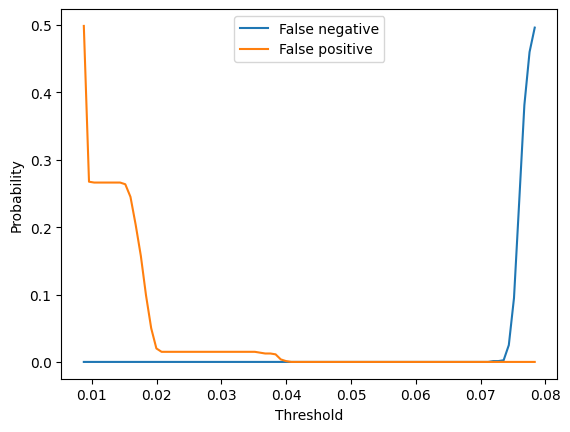

In [26]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [27]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


  0%|          | 2/800 [00:00<00:57, 13.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


  0%|          | 4/800 [00:00<00:53, 14.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0763


  1%|          | 6/800 [00:00<00:53, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


  1%|          | 8/800 [00:00<00:52, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


  1%|▏         | 10/800 [00:00<00:53, 14.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


  2%|▏         | 12/800 [00:00<00:51, 15.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0759


  2%|▏         | 14/800 [00:00<00:50, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


  2%|▏         | 16/800 [00:01<00:50, 15.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


  2%|▏         | 18/800 [00:01<00:51, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


  2%|▎         | 20/800 [00:01<00:50, 15.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0759


  3%|▎         | 22/800 [00:01<00:52, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


  3%|▎         | 24/800 [00:01<00:51, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0775


  3%|▎         | 26/800 [00:01<00:50, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0767


  4%|▎         | 28/800 [00:01<00:49, 15.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0746


  4%|▍         | 30/800 [00:01<00:49, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


  4%|▍         | 32/800 [00:02<00:50, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0778


  4%|▍         | 34/800 [00:02<00:50, 15.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0739


  4%|▍         | 36/800 [00:02<00:49, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0769


  5%|▍         | 38/800 [00:02<00:48, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


  5%|▌         | 40/800 [00:02<00:49, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0093


  5%|▌         | 42/800 [00:02<00:48, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0747


  6%|▌         | 44/800 [00:02<00:47, 16.00it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0094


  6%|▌         | 46/800 [00:02<00:48, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0199


  6%|▌         | 48/800 [00:03<00:47, 15.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


  6%|▋         | 50/800 [00:03<00:47, 15.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0753


  6%|▋         | 52/800 [00:03<00:47, 15.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


  7%|▋         | 54/800 [00:03<00:47, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0192


  7%|▋         | 56/800 [00:03<00:48, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


  7%|▋         | 58/800 [00:03<00:49, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


  8%|▊         | 60/800 [00:03<00:48, 15.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0776


  8%|▊         | 62/800 [00:04<00:49, 15.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0756


  8%|▊         | 64/800 [00:04<00:50, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0753


  8%|▊         | 66/800 [00:04<00:49, 14.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


  8%|▊         | 68/800 [00:04<00:48, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


  9%|▉         | 70/800 [00:04<00:47, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


  9%|▉         | 72/800 [00:04<00:49, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


  9%|▉         | 74/800 [00:04<00:47, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0168


 10%|▉         | 76/800 [00:04<00:47, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 10%|▉         | 78/800 [00:05<00:48, 14.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0159


 10%|█         | 80/800 [00:05<00:46, 15.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 10%|█         | 82/800 [00:05<00:45, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0194


 10%|█         | 84/800 [00:05<00:44, 15.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 11%|█         | 86/800 [00:05<00:47, 15.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 11%|█         | 88/800 [00:05<00:46, 15.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 11%|█▏        | 90/800 [00:05<00:55, 12.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0396


 12%|█▏        | 92/800 [00:06<00:55, 12.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 12%|█▏        | 94/800 [00:06<00:53, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0752


 12%|█▏        | 96/800 [00:06<00:50, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


 12%|█▏        | 98/800 [00:06<00:49, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 12%|█▎        | 100/800 [00:06<00:48, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0169


 13%|█▎        | 102/800 [00:06<00:49, 14.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 13%|█▎        | 104/800 [00:06<00:49, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0770


 13%|█▎        | 106/800 [00:07<00:48, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0776


 14%|█▎        | 108/800 [00:07<00:49, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0199


 14%|█▍        | 110/800 [00:07<00:46, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 14%|█▍        | 112/800 [00:07<00:45, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0752


 14%|█▍        | 114/800 [00:07<00:45, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 14%|█▍        | 116/800 [00:07<00:45, 14.91it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0398


 15%|█▍        | 118/800 [00:07<00:50, 13.38it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0094


 15%|█▌        | 120/800 [00:08<01:00, 11.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0770


 15%|█▌        | 122/800 [00:08<01:00, 11.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0173


 16%|█▌        | 124/800 [00:08<00:58, 11.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0756


 16%|█▌        | 126/800 [00:08<00:58, 11.47it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0763


 16%|█▌        | 128/800 [00:08<00:59, 11.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0190


 16%|█▋        | 130/800 [00:09<00:58, 11.43it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0760


 16%|█▋        | 132/800 [00:09<01:00, 10.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0751


 17%|█▋        | 134/800 [00:09<01:01, 10.90it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0171


 17%|█▋        | 136/800 [00:09<01:01, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0177


 17%|█▋        | 138/800 [00:09<01:00, 10.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0164


 18%|█▊        | 140/800 [00:09<00:58, 11.29it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0755


 18%|█▊        | 142/800 [00:10<00:57, 11.49it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0088


 18%|█▊        | 144/800 [00:10<00:57, 11.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0763


 18%|█▊        | 146/800 [00:10<00:53, 12.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 18%|█▊        | 148/800 [00:10<00:49, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 19%|█▉        | 150/800 [00:10<00:47, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0766


 19%|█▉        | 152/800 [00:10<00:46, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0752


 19%|█▉        | 154/800 [00:10<00:45, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0757


 20%|█▉        | 156/800 [00:11<00:45, 14.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0765


 20%|█▉        | 158/800 [00:11<00:46, 13.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 20%|██        | 160/800 [00:11<00:44, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0763


 20%|██        | 162/800 [00:11<00:42, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0766


 20%|██        | 164/800 [00:11<00:42, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 21%|██        | 166/800 [00:11<00:42, 15.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0758


 21%|██        | 168/800 [00:11<00:42, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 21%|██▏       | 170/800 [00:12<00:42, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0759


 22%|██▏       | 172/800 [00:12<00:42, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 22%|██▏       | 174/800 [00:12<00:43, 14.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0766


 22%|██▏       | 176/800 [00:12<00:42, 14.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 22%|██▏       | 178/800 [00:12<00:42, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0757


 22%|██▎       | 180/800 [00:12<00:42, 14.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0757


 23%|██▎       | 182/800 [00:12<00:41, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 23%|██▎       | 184/800 [00:13<00:40, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 23%|██▎       | 186/800 [00:13<00:40, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0764


 24%|██▎       | 188/800 [00:13<00:40, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0776


 24%|██▍       | 190/800 [00:13<00:40, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0774


 24%|██▍       | 192/800 [00:13<00:40, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0769


 24%|██▍       | 194/800 [00:13<00:40, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0760


 24%|██▍       | 196/800 [00:13<00:41, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 25%|██▍       | 198/800 [00:13<00:40, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0743


 25%|██▌       | 200/800 [00:14<00:41, 14.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0768


 25%|██▌       | 202/800 [00:14<00:41, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0758


 26%|██▌       | 204/800 [00:14<00:40, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0757


 26%|██▌       | 206/800 [00:14<00:39, 15.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0749


 26%|██▌       | 208/800 [00:14<00:39, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0761


 26%|██▋       | 210/800 [00:14<00:38, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 26%|██▋       | 212/800 [00:14<00:38, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 27%|██▋       | 214/800 [00:15<00:37, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0770


 27%|██▋       | 216/800 [00:15<00:39, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 27%|██▋       | 218/800 [00:15<00:39, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 28%|██▊       | 220/800 [00:15<00:39, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 28%|██▊       | 222/800 [00:15<00:38, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0768


 28%|██▊       | 224/800 [00:15<00:38, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 28%|██▊       | 226/800 [00:15<00:38, 15.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 28%|██▊       | 228/800 [00:15<00:38, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0756


 29%|██▉       | 230/800 [00:16<00:37, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 29%|██▉       | 232/800 [00:16<00:37, 15.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0168


 29%|██▉       | 234/800 [00:16<00:38, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0754


 30%|██▉       | 236/800 [00:16<00:37, 15.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0759


 30%|██▉       | 238/800 [00:16<00:37, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 30%|███       | 240/800 [00:16<00:37, 15.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0156


 30%|███       | 242/800 [00:16<00:37, 14.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0739


 30%|███       | 244/800 [00:17<00:37, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0766


 31%|███       | 246/800 [00:17<00:39, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0755


 31%|███       | 248/800 [00:17<00:37, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0769


 31%|███▏      | 250/800 [00:17<00:37, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0750


 32%|███▏      | 252/800 [00:17<00:36, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 32%|███▏      | 254/800 [00:17<00:35, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0775


 32%|███▏      | 256/800 [00:17<00:35, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0779


 32%|███▏      | 258/800 [00:17<00:36, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 32%|███▎      | 260/800 [00:18<00:36, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 33%|███▎      | 262/800 [00:18<00:35, 15.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0170


 33%|███▎      | 264/800 [00:18<00:36, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 33%|███▎      | 266/800 [00:18<00:35, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0775


 34%|███▎      | 268/800 [00:18<00:35, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 34%|███▍      | 270/800 [00:18<00:35, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 34%|███▍      | 272/800 [00:18<00:34, 15.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0171


 34%|███▍      | 274/800 [00:19<00:34, 15.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


 34%|███▍      | 276/800 [00:19<00:33, 15.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 35%|███▍      | 278/800 [00:19<00:34, 15.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 35%|███▌      | 280/800 [00:19<00:35, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0753


 35%|███▌      | 282/800 [00:19<00:35, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0166


 36%|███▌      | 284/800 [00:19<00:34, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0753


 36%|███▌      | 286/800 [00:19<00:35, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 36%|███▌      | 288/800 [00:19<00:34, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0163


 36%|███▋      | 290/800 [00:20<00:33, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 36%|███▋      | 292/800 [00:20<00:34, 14.64it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0740


 37%|███▋      | 294/800 [00:20<00:37, 13.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0750


 37%|███▋      | 296/800 [00:20<00:40, 12.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0176


 37%|███▋      | 298/800 [00:20<00:41, 12.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 38%|███▊      | 300/800 [00:20<00:42, 11.70it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0152


 38%|███▊      | 302/800 [00:21<00:41, 11.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0765


 38%|███▊      | 304/800 [00:21<00:42, 11.76it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0088


 38%|███▊      | 306/800 [00:21<00:46, 10.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0094


 38%|███▊      | 308/800 [00:21<00:45, 10.78it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0766


 39%|███▉      | 310/800 [00:21<00:45, 10.82it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0772


 39%|███▉      | 312/800 [00:22<00:45, 10.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0774


 39%|███▉      | 314/800 [00:22<00:45, 10.65it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0743


 40%|███▉      | 316/800 [00:22<00:45, 10.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0088


 40%|███▉      | 318/800 [00:22<00:45, 10.57it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0165


 40%|████      | 320/800 [00:22<00:44, 10.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 40%|████      | 322/800 [00:23<00:43, 11.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0751


 40%|████      | 324/800 [00:23<00:40, 11.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0755


 41%|████      | 326/800 [00:23<00:37, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0756


 41%|████      | 328/800 [00:23<00:35, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 41%|████▏     | 330/800 [00:23<00:35, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 42%|████▏     | 332/800 [00:23<00:33, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 42%|████▏     | 334/800 [00:23<00:32, 14.37it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0088


 42%|████▏     | 336/800 [00:23<00:31, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 42%|████▏     | 338/800 [00:24<00:31, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0760


 42%|████▎     | 340/800 [00:24<00:31, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 43%|████▎     | 342/800 [00:24<00:31, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 43%|████▎     | 344/800 [00:24<00:31, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0761


 43%|████▎     | 346/800 [00:24<00:31, 14.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0093


 44%|████▎     | 348/800 [00:24<00:30, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


 44%|████▍     | 350/800 [00:24<00:29, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 44%|████▍     | 352/800 [00:25<00:28, 15.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0763


 44%|████▍     | 354/800 [00:25<00:29, 15.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0748


 44%|████▍     | 356/800 [00:25<00:30, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0759


 45%|████▍     | 358/800 [00:25<00:29, 14.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0770


 45%|████▌     | 360/800 [00:25<00:29, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0200


 45%|████▌     | 362/800 [00:25<00:29, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 46%|████▌     | 364/800 [00:25<00:29, 14.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0756


 46%|████▌     | 366/800 [00:25<00:29, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0195


 46%|████▌     | 368/800 [00:26<00:29, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0764


 46%|████▋     | 370/800 [00:26<00:29, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 46%|████▋     | 372/800 [00:26<00:29, 14.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 47%|████▋     | 374/800 [00:26<00:29, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0749


 47%|████▋     | 376/800 [00:26<00:29, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 47%|████▋     | 378/800 [00:26<00:29, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 48%|████▊     | 380/800 [00:26<00:29, 14.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0756


 48%|████▊     | 382/800 [00:27<00:29, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0766


 48%|████▊     | 384/800 [00:27<00:29, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0747


 48%|████▊     | 386/800 [00:27<00:29, 14.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 48%|████▊     | 388/800 [00:27<00:28, 14.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0748


 49%|████▉     | 390/800 [00:27<00:29, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 49%|████▉     | 392/800 [00:27<00:28, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0751


 49%|████▉     | 394/800 [00:27<00:29, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 50%|████▉     | 396/800 [00:28<00:28, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 50%|████▉     | 398/800 [00:28<00:27, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 50%|█████     | 400/800 [00:28<00:27, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 50%|█████     | 402/800 [00:28<00:27, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0755


 50%|█████     | 404/800 [00:28<00:27, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 51%|█████     | 406/800 [00:28<00:27, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 51%|█████     | 408/800 [00:28<00:27, 14.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 51%|█████▏    | 410/800 [00:29<00:27, 14.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 52%|█████▏    | 412/800 [00:29<00:27, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0778


 52%|█████▏    | 414/800 [00:29<00:27, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0761


 52%|█████▏    | 416/800 [00:29<00:27, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0769


 52%|█████▏    | 418/800 [00:29<00:27, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 52%|█████▎    | 420/800 [00:29<00:26, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0765


 53%|█████▎    | 422/800 [00:29<00:27, 13.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0742


 53%|█████▎    | 424/800 [00:30<00:27, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0757


 53%|█████▎    | 426/800 [00:30<00:27, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0166


 54%|█████▎    | 428/800 [00:30<00:27, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0753


 54%|█████▍    | 430/800 [00:30<00:26, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 54%|█████▍    | 432/800 [00:30<00:26, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0746


 54%|█████▍    | 434/800 [00:30<00:26, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 55%|█████▍    | 436/800 [00:30<00:26, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0742


 55%|█████▍    | 438/800 [00:31<00:26, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 55%|█████▌    | 440/800 [00:31<00:26, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0093


 55%|█████▌    | 442/800 [00:31<00:25, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0743


 56%|█████▌    | 444/800 [00:31<00:24, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 56%|█████▌    | 446/800 [00:31<00:24, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 56%|█████▌    | 448/800 [00:31<00:24, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0168


 56%|█████▋    | 450/800 [00:31<00:23, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


 56%|█████▋    | 452/800 [00:32<00:23, 14.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0757


 57%|█████▋    | 454/800 [00:32<00:24, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0753


 57%|█████▋    | 456/800 [00:32<00:23, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0758


 57%|█████▋    | 458/800 [00:32<00:24, 14.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0164


 57%|█████▊    | 460/800 [00:32<00:23, 14.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 58%|█████▊    | 462/800 [00:32<00:22, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 58%|█████▊    | 464/800 [00:32<00:22, 15.04it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0773


 58%|█████▊    | 466/800 [00:33<00:23, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0155


 58%|█████▊    | 468/800 [00:33<00:26, 12.65it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0753


 59%|█████▉    | 470/800 [00:33<00:27, 11.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 59%|█████▉    | 472/800 [00:33<00:28, 11.47it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0093


 59%|█████▉    | 474/800 [00:33<00:29, 11.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0757


 60%|█████▉    | 476/800 [00:33<00:29, 10.90it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0088


 60%|█████▉    | 478/800 [00:34<00:29, 10.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0179


 60%|██████    | 480/800 [00:34<00:29, 11.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0760


 60%|██████    | 482/800 [00:34<00:29, 10.84it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0088


 60%|██████    | 484/800 [00:34<00:29, 10.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0088


 61%|██████    | 486/800 [00:34<00:29, 10.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0762


 61%|██████    | 488/800 [00:35<00:29, 10.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0163


 61%|██████▏   | 490/800 [00:35<00:28, 11.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0745


 62%|██████▏   | 492/800 [00:35<00:28, 10.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0746


 62%|██████▏   | 494/800 [00:35<00:26, 11.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 62%|██████▏   | 496/800 [00:35<00:24, 12.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0095


 62%|██████▏   | 498/800 [00:35<00:23, 13.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0751


 62%|██████▎   | 500/800 [00:36<00:22, 13.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0752


 63%|██████▎   | 502/800 [00:36<00:22, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0093


 63%|██████▎   | 504/800 [00:36<00:20, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 63%|██████▎   | 506/800 [00:36<00:20, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 64%|██████▎   | 508/800 [00:36<00:20, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0168


 64%|██████▍   | 510/800 [00:36<00:20, 14.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0767


 64%|██████▍   | 512/800 [00:36<00:20, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0750


 64%|██████▍   | 514/800 [00:36<00:20, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0770


 64%|██████▍   | 516/800 [00:37<00:19, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0162


 65%|██████▍   | 518/800 [00:37<00:19, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0197


 65%|██████▌   | 520/800 [00:37<00:19, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0777


 65%|██████▌   | 522/800 [00:37<00:19, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 66%|██████▌   | 524/800 [00:37<00:19, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


 66%|██████▌   | 526/800 [00:37<00:19, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 66%|██████▌   | 528/800 [00:37<00:18, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 66%|██████▋   | 530/800 [00:38<00:18, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 66%|██████▋   | 532/800 [00:38<00:18, 14.52it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0762


 67%|██████▋   | 534/800 [00:38<00:18, 14.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0385


 67%|██████▋   | 536/800 [00:38<00:18, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0750


 67%|██████▋   | 538/800 [00:38<00:18, 14.51it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0088


 68%|██████▊   | 540/800 [00:38<00:17, 14.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 68%|██████▊   | 542/800 [00:38<00:17, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 68%|██████▊   | 544/800 [00:39<00:17, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0760


 68%|██████▊   | 546/800 [00:39<00:17, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0165


 68%|██████▊   | 548/800 [00:39<00:17, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 69%|██████▉   | 550/800 [00:39<00:16, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0748


 69%|██████▉   | 552/800 [00:39<00:16, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0746


 69%|██████▉   | 554/800 [00:39<00:16, 15.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 70%|██████▉   | 556/800 [00:39<00:17, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 70%|██████▉   | 558/800 [00:40<00:17, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0771


 70%|███████   | 560/800 [00:40<00:16, 14.35it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0743


 70%|███████   | 562/800 [00:40<00:16, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 70%|███████   | 564/800 [00:40<00:16, 14.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0095


 71%|███████   | 566/800 [00:40<00:16, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 71%|███████   | 568/800 [00:40<00:16, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 71%|███████▏  | 570/800 [00:40<00:16, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 72%|███████▏  | 572/800 [00:41<00:26,  8.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0088


 72%|███████▏  | 574/800 [00:41<00:24,  9.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 72%|███████▏  | 576/800 [00:41<00:22, 10.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 72%|███████▏  | 578/800 [00:41<00:20, 10.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0088


 72%|███████▎  | 580/800 [00:41<00:19, 11.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0155


 73%|███████▎  | 582/800 [00:42<00:18, 11.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 73%|███████▎  | 584/800 [00:42<00:17, 12.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0764


 73%|███████▎  | 586/800 [00:42<00:17, 12.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 74%|███████▎  | 588/800 [00:42<00:17, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0752


 74%|███████▍  | 590/800 [00:42<00:16, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0361


 74%|███████▍  | 592/800 [00:42<00:16, 12.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0759


 74%|███████▍  | 594/800 [00:43<00:16, 12.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0761


 74%|███████▍  | 596/800 [00:43<00:16, 12.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0168


 75%|███████▍  | 598/800 [00:43<00:15, 12.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0191


 75%|███████▌  | 600/800 [00:43<00:15, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0750


 75%|███████▌  | 602/800 [00:43<00:15, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 76%|███████▌  | 604/800 [00:43<00:15, 13.06it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0759


 76%|███████▌  | 606/800 [00:44<00:15, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 76%|███████▌  | 608/800 [00:44<00:15, 12.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0752


 76%|███████▋  | 610/800 [00:44<00:15, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0758


 76%|███████▋  | 612/800 [00:44<00:14, 12.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 77%|███████▋  | 614/800 [00:44<00:14, 12.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0756


 77%|███████▋  | 616/800 [00:44<00:14, 12.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0762


 77%|███████▋  | 618/800 [00:44<00:13, 13.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0746


 78%|███████▊  | 620/800 [00:45<00:13, 12.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0753


 78%|███████▊  | 622/800 [00:45<00:13, 12.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0171


 78%|███████▊  | 624/800 [00:45<00:13, 12.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0774


 78%|███████▊  | 626/800 [00:45<00:14, 12.14it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0185


 78%|███████▊  | 628/800 [00:45<00:15, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0170


 79%|███████▉  | 630/800 [00:45<00:15, 10.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0758


 79%|███████▉  | 632/800 [00:46<00:15, 10.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0088


 79%|███████▉  | 634/800 [00:46<00:15, 10.97it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0161


 80%|███████▉  | 636/800 [00:46<00:15, 10.67it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0093


 80%|███████▉  | 638/800 [00:46<00:15, 10.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0760


 80%|████████  | 640/800 [00:46<00:15, 10.58it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0088


 80%|████████  | 642/800 [00:47<00:14, 10.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0741


 80%|████████  | 644/800 [00:47<00:14, 10.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0093


 81%|████████  | 646/800 [00:47<00:15,  9.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0760


 81%|████████  | 647/800 [00:47<00:15,  9.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0170


 81%|████████  | 649/800 [00:47<00:15, 10.00it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0756


 81%|████████▏ | 651/800 [00:48<00:14, 10.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0191


 82%|████████▏ | 653/800 [00:48<00:14, 10.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0747


 82%|████████▏ | 655/800 [00:48<00:13, 10.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 82%|████████▏ | 657/800 [00:48<00:12, 11.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0387


 82%|████████▏ | 659/800 [00:48<00:11, 12.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0764


 83%|████████▎ | 661/800 [00:48<00:10, 12.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 83%|████████▎ | 663/800 [00:48<00:10, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 83%|████████▎ | 665/800 [00:49<00:09, 13.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0744


 83%|████████▎ | 667/800 [00:49<00:09, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0088


 84%|████████▎ | 669/800 [00:49<00:09, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0752


 84%|████████▍ | 671/800 [00:49<00:09, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 84%|████████▍ | 673/800 [00:49<00:09, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 84%|████████▍ | 675/800 [00:49<00:08, 14.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0772


 85%|████████▍ | 677/800 [00:49<00:08, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 85%|████████▍ | 679/800 [00:50<00:08, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0195


 85%|████████▌ | 681/800 [00:50<00:08, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 85%|████████▌ | 683/800 [00:50<00:08, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0779


 86%|████████▌ | 685/800 [00:50<00:08, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 86%|████████▌ | 687/800 [00:50<00:07, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0750


 86%|████████▌ | 689/800 [00:50<00:07, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0767


 86%|████████▋ | 691/800 [00:50<00:07, 14.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0782


 87%|████████▋ | 693/800 [00:51<00:07, 14.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0751


 87%|████████▋ | 695/800 [00:51<00:07, 14.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0754


 87%|████████▋ | 697/800 [00:51<00:07, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 87%|████████▋ | 699/800 [00:51<00:07, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0756


 88%|████████▊ | 701/800 [00:51<00:07, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0767


 88%|████████▊ | 703/800 [00:51<00:06, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0766


 88%|████████▊ | 705/800 [00:51<00:06, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0088


 88%|████████▊ | 707/800 [00:52<00:06, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0770


 89%|████████▊ | 709/800 [00:52<00:06, 14.35it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0753


 89%|████████▉ | 711/800 [00:52<00:06, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0746


 89%|████████▉ | 713/800 [00:52<00:06, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0759


 89%|████████▉ | 715/800 [00:52<00:06, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 90%|████████▉ | 717/800 [00:52<00:05, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0766


 90%|████████▉ | 719/800 [00:52<00:05, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


 90%|█████████ | 721/800 [00:53<00:05, 14.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0092


 90%|█████████ | 723/800 [00:53<00:05, 14.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0767


 91%|█████████ | 725/800 [00:53<00:05, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0753


 91%|█████████ | 727/800 [00:53<00:05, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0765


 91%|█████████ | 729/800 [00:53<00:05, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0759


 91%|█████████▏| 731/800 [00:53<00:04, 14.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0093


 92%|█████████▏| 733/800 [00:53<00:04, 14.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 92%|█████████▏| 735/800 [00:54<00:04, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 92%|█████████▏| 737/800 [00:54<00:04, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0746


 92%|█████████▏| 739/800 [00:54<00:04, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


 93%|█████████▎| 741/800 [00:54<00:04, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0775


 93%|█████████▎| 743/800 [00:54<00:04, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0747


 93%|█████████▎| 745/800 [00:54<00:03, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0757


 93%|█████████▎| 747/800 [00:54<00:03, 14.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0739


 94%|█████████▎| 749/800 [00:55<00:03, 14.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0771


 94%|█████████▍| 751/800 [00:55<00:03, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0764


 94%|█████████▍| 753/800 [00:55<00:03, 14.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0771


 94%|█████████▍| 755/800 [00:55<00:03, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 95%|█████████▍| 757/800 [00:55<00:02, 14.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0176


 95%|█████████▍| 759/800 [00:55<00:02, 14.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0750


 95%|█████████▌| 761/800 [00:55<00:02, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 95%|█████████▌| 763/800 [00:55<00:02, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0761


 96%|█████████▌| 765/800 [00:56<00:02, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 96%|█████████▌| 767/800 [00:56<00:02, 14.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0779


 96%|█████████▌| 769/800 [00:56<00:02, 14.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 96%|█████████▋| 771/800 [00:56<00:02, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0087


 97%|█████████▋| 773/800 [00:56<00:01, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0755


 97%|█████████▋| 775/800 [00:56<00:01, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 97%|█████████▋| 777/800 [00:56<00:01, 13.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0765


 97%|█████████▋| 779/800 [00:57<00:01, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0746


 98%|█████████▊| 781/800 [00:57<00:01, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0774


 98%|█████████▊| 783/800 [00:57<00:01, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0750


 98%|█████████▊| 785/800 [00:57<00:01, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0164


 98%|█████████▊| 787/800 [00:57<00:00, 13.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 99%|█████████▊| 789/800 [00:57<00:00, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 99%|█████████▉| 791/800 [00:58<00:00, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0741


 99%|█████████▉| 793/800 [00:58<00:00, 13.80it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 99%|█████████▉| 795/800 [00:58<00:00, 13.43it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0095


100%|█████████▉| 797/800 [00:58<00:00, 12.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


100%|█████████▉| 799/800 [00:58<00:00, 12.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0093


100%|██████████| 800/800 [00:58<00:00, 13.61it/s]


In [28]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 90.875 %


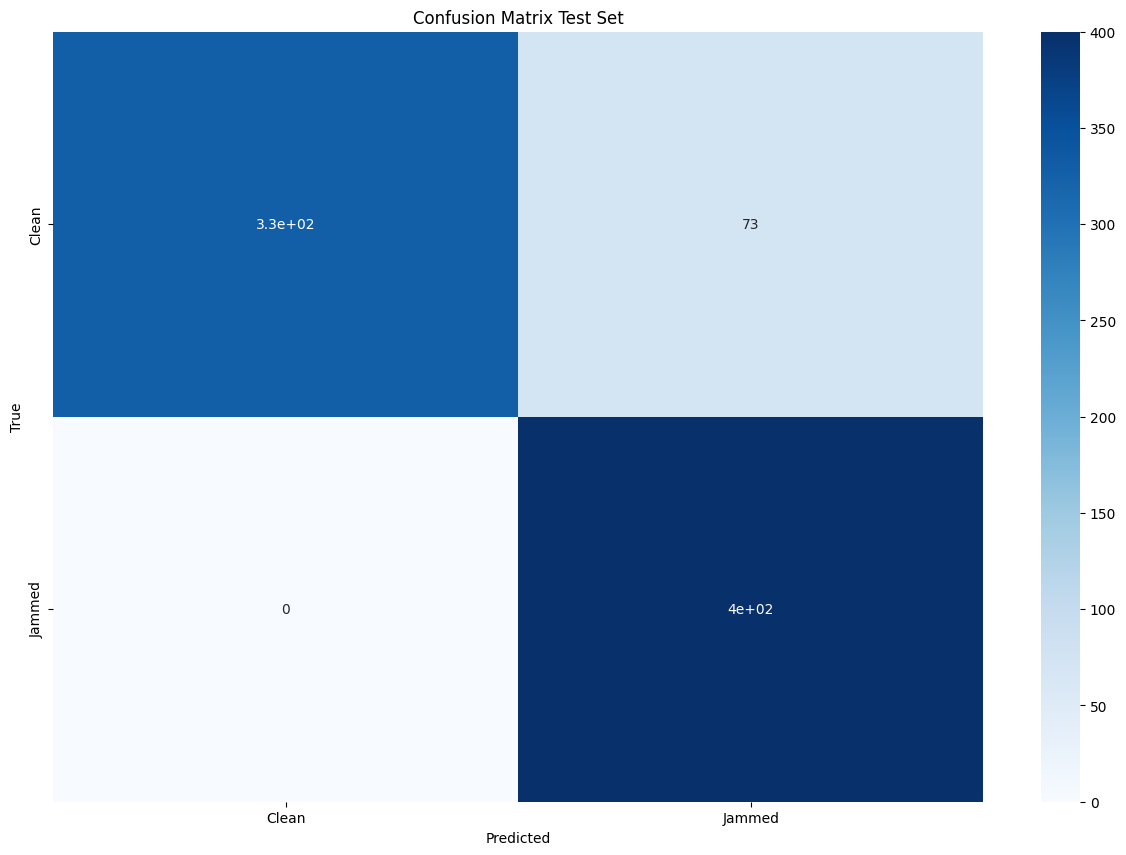

In [29]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold